In [1]:
import numpy as np

import matplotlib.pyplot as plt
# 设置 Matplotlib 使用支持中文的字体
# plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows 用户
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # macOS 用户
# plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']  # Linux 用户
# 解决负号 '-' 显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

from pyswarm import pso

import CDPD_control_dual as model_sim
import CDPD_simplify_half_compare as model_opt
import mytoolkit as tool
import CDPD_control_dual_parameters as param
import PIDcontroller as PID
import optimization as opt

SimulationConfig(t0=0, tf=100, fps=100, rtol=1e-06, atol=1e-06)
100.0
[5.00e+01 2.00e+01 2.00e+01 2.00e+01 4.00e+01 1.00e+01 0.00e+00 1.00e+05
 1.00e+05 1.00e+03 3.00e+05 1.00e+03 9.81e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
[ 0.         17.32050808 -1.57079633 -1.57079633  0.52359878  1.57079633
  1.57079633  0.          0.          0.          0.          0.        ]


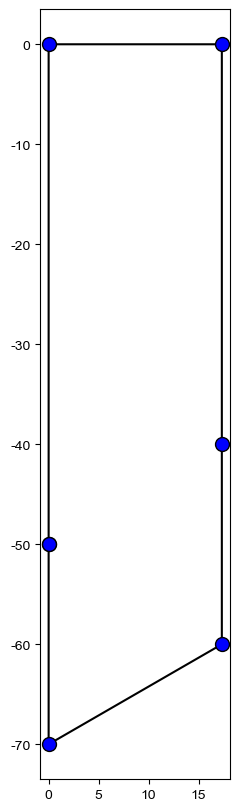

In [31]:
startSimulation =param.CDPDInitialParam(structure_paras=np.array([50, 20, 20,20, 40, 10,0]),weight_paras=np.array([100e3,100e3,1e3,300e3,1e3,9.81]))

config = model_opt.SimulationConfig(0,100,100,1e-6,1e-6)

desired_settling_time = startSimulation.getDesired_settling_time()
print(config)
print(desired_settling_time)

p_vals_CDPD = startSimulation.getParameters_CDPD()
x0_CDPD = startSimulation.getInitialStates_CDPD()
print(p_vals_CDPD)
print(x0_CDPD)
model_opt.CDPD(p_vals_CDPD).setup_figure_plot(x0_CDPD,p_vals_CDPD)


这个系统的优化和哪些东西有关，控制力的大小，ITAE最小的优化目标和目标时间有关，需要计算ITAE本身的最小值是多少

In [ ]:

def compute_Pp(d, h, l1, l2, theta1, theta2, theta3):
    """
    计算点 P_p 的坐标（x, y）。
    P_p = (d cosθ3 - h sinθ3 + l1 cosθ1 + l2 cosθ2) · e_x
        + (d sinθ3 + h cosθ3 + l1 sinθ1 + l2 sinθ2) · e_y
    返回一个长度为2的 numpy 数组 [x, y]。
    """
    x = d * np.cos(theta3) - h * np.sin(theta3) \
        + l1 * np.cos(theta1) + l2 * np.cos(theta2)
    y = d * np.sin(theta3) + h * np.cos(theta3) \
        + l1 * np.sin(theta1) + l2 * np.sin(theta2)
    return np.array([x, y])

def compute_Pp_position(system):
    """
    计算点 P_p 的坐标（x, y）。
    P_p = (d cosθ3 - h sinθ3 + l1 cosθ1 + l2 cosθ2) · e_x
        + (d sinθ3 + h cosθ3 + l1 sinθ1 + l2 sinθ2) · e_y
    """
    d = system.params[5]
    h = system.params[6]
    l1 = system.params[0]
    l2 = system.params[1]
    theta1 = system.xs_dae[:, 2]
    theta2 = system.xs_dae[:, 3]
    theta3 = system.xs_dae[:, 4]
    return compute_Pp(d, h, l1, l2, theta1, theta2, theta3)


def compute_Pp_velocity(system):
    """
    计算点 P_p 的坐标（x, y）。
    P_p = (d cosθ3 - h sinθ3 + l1 cosθ1 + l2 cosθ2) · e_x
        + (d sinθ3 + h cosθ3 + l1 sinθ1 + l2 sinθ2) · e_y
    返回一个长度为2的 numpy 数组 [x, y]。
    """
    theta1 = system.xs_dae[:,2]
    theta2 = system.xs_dae[:,3]
    theta3 = system.xs_dae[:,4]
    ux1 = system.xs_dae[:,7]
    u1 = system.xs_dae[:,9]
    u2 = system.xs_dae[:,10]
    u3, _ = system.compute_u3_u4(system.xs_dae)

    vel = ux1 - np.sin(theta3)*u3 - np.sin(theta1)*u1 - np.sin(theta2)*u2
    
    return vel

def IAEV_calc_p(target,system) -> float:
    """
    计算 ITAE（积分绝对误差），用于评价控制性能。
    如果仿真失败（ts 或 states 为空），返回一个较大的惩罚值。
    对于每个目标维度计算 ITAE，然后求和。
    """
    if len(system.ts_dae) == 0 or len(system.xs_dae) == 0:
        print("仿真失败，返回惩罚值")
        return 1e12
    xpr = compute_Pp_position(system)
    x1 = system.xs_dae[:, 0]  # 初始位置 x1
    xp = x1 + xpr[:,0]  # 计算载荷位置 x_p
    ts = system.ts_dae
    sum_ITAEV = 0.0
    # 假设 states 的每一列对应一个目标变量
    errors = target - xp
    vp = compute_Pp_velocity(system)
    sum_ITAEV += compute_iaev(ts, errors, vp)
    return sum_ITAEV

def IAEV_calc_c1(target,system) -> float:
    """
    计算 ITAE（积分绝对误差），用于评价控制性能。
    如果仿真失败（ts 或 states 为空），返回一个较大的惩罚值。
    对于每个目标维度计算 ITAE，然后求和。
    """
    if len(system.ts_dae) == 0 or len(system.xs_dae) == 0:
        print("仿真失败，返回惩罚值")
        return 1e12

    x1 = system.xs_dae[:, 0]  # 初始位置 x1
    ts = system.ts_dae
    v1 = system.xs_dae[:,7]
    sum_ITAEV = 0.0
    # 假设 states 的每一列对应一个目标变量
    errors = target - x1
    sum_ITAEV += compute_iaev(ts, errors, v1)
    return sum_ITAEV

def IAEV_calc_c2(target,system) -> float:
    """
    计算 ITAE（积分绝对误差），用于评价控制性能。
    如果仿真失败（ts 或 states 为空），返回一个较大的惩罚值。
    对于每个目标维度计算 ITAE，然后求和。
    """
    if len(system.ts_dae) == 0 or len(system.xs_dae) == 0:
        print("仿真失败，返回惩罚值")
        return 1e12

    x2 = system.xs_dae[:, 1]  # 初始位置 x2
    ts = system.ts_dae
    v2 = system.xs_dae[:,8]
    sum_ITAEV = 0.0
    # 假设 states 的每一列对应一个目标变量
    errors = target - x2
    sum_ITAEV += compute_iaev(ts, errors, v2)
    return sum_ITAEV

def compute_iaev(time: np.ndarray, error: np.ndarray, velocity: np.ndarray) -> float:
    """
    计算 IAE：在误差绝对值基础上乘以时间后进行积分
    """

    radiuls = np.sqrt(error**2 + velocity**2)
    return np.trapz(radiuls, time)

def IAE_calc(target,p, ts: np.ndarray, states: np.ndarray) -> float:
    """
    计算 ITAE（积分时间加权绝对误差），用于评价控制性能。
    如果仿真失败（ts 或 states 为空），返回一个较大的惩罚值。
    对于每个目标维度计算 ITAE，然后求和。
    """
    if len(ts) == 0 or len(states) == 0:
        print("仿真失败，返回惩罚值")
        return 1e12
    x1 = states[:, 0]  # 初始位置 x1
    theta1 = states[:, 2]  # 初始角度 theta1
    theta2 = states[:, 3]  # 初始角度 theta2
    theta3 = states[:, 4]  # 初始角度 theta3
    d = p[5]  # 假设 p[5] 是 d
    h = p[6]  # 假设 p[6] 是 h
    l1 = p[0]  # 假设 p[0] 是 l1
    l2 = p[1]  # 假设 p[1] 是 l2
    pos_p = [compute_Pp(d, h, l1, l2, t1, t2, t3) for t1, t2, t3 in zip(theta1, theta2, theta3)]
    xp =  x1 + np.array(pos_p)[:,0]  # 计算载荷位置 x_p
    sum_ITAE = 0.0
    # 假设 states 的每一列对应一个目标变量
    errors = target - xp
    sum_ITAE += compute_iae(ts, errors)
    return sum_ITAE

def compute_iae(time: np.ndarray, error: np.ndarray) -> float:
    """
    计算 IAE：在误差绝对值基础上乘以时间后进行积分
    """
    weighted_error = np.abs(error)
    return np.trapz(weighted_error, time)
def ITAE_calc(target,p, ts: np.ndarray, states: np.ndarray) -> float:
    """
    计算 ITAE（积分时间加权绝对误差），用于评价控制性能。
    如果仿真失败（ts 或 states 为空），返回一个较大的惩罚值。
    对于每个目标维度计算 ITAE，然后求和。
    """
    if len(ts) == 0 or len(states) == 0:
        print("仿真失败，返回惩罚值")
        return 1e12
    x1 = states[:, 0]  # 初始位置 x1
    theta1 = states[:, 2]  # 初始角度 theta1
    theta2 = states[:, 3]  # 初始角度 theta2
    theta3 = states[:, 4]  # 初始角度 theta3
    d = p[5]  # 假设 p[5] 是 d
    h = p[6]  # 假设 p[6] 是 h
    l1 = p[0]  # 假设 p[0] 是 l1
    l2 = p[1]  # 假设 p[1] 是 l2
    pos_p = [compute_Pp(d, h, l1, l2, t1, t2, t3) for t1, t2, t3 in zip(theta1, theta2, theta3)]
    xp = x1 + np.array(pos_p)[:,0]  # 计算载荷位置 x_p
    sum_ITAE = 0.0
    # 假设 states 的每一列对应一个目标变量
    errors = target - xp
    sum_ITAE += compute_itae(ts, errors)
    return sum_ITAE

def compute_itae(time: np.ndarray, error: np.ndarray) -> float:
    """
    计算 IAE：在误差绝对值基础上乘以时间后进行积分
    """
    weighted_error = np.abs(error)*time
    return np.trapz(weighted_error, time)

def ITAE_calc_x1(target, ts: np.ndarray, states: np.ndarray) -> float:
    """
    计算 ITAE（积分时间加权绝对误差），用于评价控制性能。
    如果仿真失败（ts 或 states 为空），返回一个较大的惩罚值。
    对于每个目标维度计算 ITAE，然后求和。
    """
    xc1 = states[:, 0]  # 初始位置 x0
    sum_ITAE = 0.0
    # 假设 states 的每一列对应一个目标变量
    errors = target - xc1
    sum_ITAE += compute_itae(ts, errors)
    return sum_ITAE
def ITAE_calc_x2(target, ts: np.ndarray, states: np.ndarray) -> float:
    """
    计算 ITAE（积分时间加权绝对误差），用于评价控制性能。
    如果仿真失败（ts 或 states 为空），返回一个较大的惩罚值。
    对于每个目标维度计算 ITAE，然后求和。
    """
    xc2 = states[:, 1]  # 初始位置 x0
    sum_ITAE = 0.0
    # 假设 states 的每一列对应一个目标变量
    errors = target - xc2
    sum_ITAE += compute_itae(ts, errors)
    return sum_ITAE

def IAE_calc_x1(target, ts: np.ndarray, states: np.ndarray) -> float:
    """
    计算 IAE（积分绝对误差），用于评价控制性能。
    如果仿真失败（ts 或 states 为空），返回一个较大的惩罚值。
    对于每个目标维度计算 IAE，然后求和。
    """
    xc1 = states[:, 0]  # 初始位置 x0
    sum_IAE = 0.0
    # 假设 states 的每一列对应一个目标变量
    errors = target - xc1
    sum_IAE += compute_iae(ts, errors)
    return sum_IAE

def IAE_calc_x2(target, ts: np.ndarray, states: np.ndarray) -> float:
    """
    计算 IAE（积分绝对误差），用于评价控制性能。
    如果仿真失败（ts 或 states 为空），返回一个较大的惩罚值。
    对于每个目标维度计算 IAE，然后求和。
    """
    xc2 = states[:, 1]  # 初始位置 x0
    sum_IAE = 0.0
    # 假设 states 的每一列对应一个目标变量
    errors = target - xc2
    sum_IAE += compute_iae(ts, errors)
    return sum_IAE

def compare_trolley_and_payload_positions_absolute(systemfunc):
    d = systemfunc.params[5]  # 假设 p_vals_CDPD[5] 是 d
    h = systemfunc.params[6]  # 假设 p_vals_CDPD[6] 是 h
    l1 = systemfunc.params[0]  # 假设 p_vals_CDPD[0] 是 l1
    l2 = systemfunc.params[1]  # 假设 p_vals_CDPD[1] 是 l2
    theta1 = systemfunc.xs_dae[:, 2]  # 假设 theta1
    theta2 = systemfunc.xs_dae[:, 3]  # 假设 theta2
    theta3 = systemfunc.xs_dae[:, 4]  # 假设 theta3
    p_p = [compute_Pp(d, h, l1, l2, theta1, theta2, theta3) for theta1, theta2, theta3 in zip(theta1, theta2, theta3)]
    ts = systemfunc.ts_dae
    x1s = systemfunc.xs_dae[:,0]-systemfunc.xs_dae[0,0]
    x2s = systemfunc.xs_dae[:,1]-systemfunc.xs_dae[0,1]
    xpl = systemfunc.xs_dae[:,0]+ np.array(p_p)[:,0] - np.array(p_p)[0,0]  # 计算载荷位置 x_p
    plot_trolley_payload_positions(ts, x1s, x2s, xpl, title="Comparison of Trolley and Payload Positions")

def compare_trolley_and_payload_positions(systemfunc):
    d = systemfunc.params[5]  # 假设 p_vals_CDPD[5] 是 d
    h = systemfunc.params[6]  # 假设 p_vals_CDPD[6] 是 h
    l1 = systemfunc.params[0]  # 假设 p_vals_CDPD[0] 是 l1
    l2 = systemfunc.params[1]  # 假设 p_vals_CDPD[1] 是 l2
    theta1 = systemfunc.xs_dae[:, 2]  # 假设 theta1
    theta2 = systemfunc.xs_dae[:, 3]  # 假设 theta2
    theta3 = systemfunc.xs_dae[:, 4]  # 假设 theta3
    p_p = [compute_Pp(d, h, l1, l2, theta1, theta2, theta3) for theta1, theta2, theta3 in zip(theta1, theta2, theta3)]
    ts = systemfunc.ts_dae
    x1s = systemfunc.xs_dae[:,0]-systemfunc.xs_dae[0,0]
    x2s = systemfunc.xs_dae[:,1]-systemfunc.xs_dae[0,1]
    # xpl = x1s + p_p[:,0]  # 计算载荷位置 x_p
    xpl = np.array(p_p)[:,0] - np.array(p_p)[0,0]  # 计算载荷位置 x_p
    plot_trolley_payload_positions(ts, x1s, x2s, xpl, title="Comparison of Trolley and Payload Positions")

def plot_trolley_payload_positions(ts,trolley_x1s,trolley_x2s,payload_xs, title="Comparison of Trolley and Payload Positions"):
    """
    Plot trolley and payload positions comparison
    title : str, optional
        Plot title (default: "Comparison of Trolley and Payload Positions")
    """
    # Extract positions and adjust for initial positions

    # Create the comparison plot
    plt.figure(figsize=(10, 3),dpi=300)
    plt.plot(ts, trolley_x1s, label='Trolley 1 Position', linewidth=2)
    plt.plot(ts, trolley_x2s, label='Trolley 2 Position', linewidth=2)
    plt.plot(ts, payload_xs, label='Payload Position', linewidth=2)

    plt.xlabel('Time [s]')
    plt.ylabel('Position [m]')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [32]:
distance = (0.0,0.0)
vp = 1 # m/s
vptheta1 = vp /(p_vals_CDPD[0]+p_vals_CDPD[1])
vptheta2 = vp /(p_vals_CDPD[3]+p_vals_CDPD[4])
x0_CDPD[7] =0
x0_CDPD[8] =0
x0_CDPD[9] =vptheta1*p_vals_CDPD[0]
x0_CDPD[10] =vptheta1*p_vals_CDPD[1]
x0_CDPD[11] =vptheta2*p_vals_CDPD[4]

print(x0_CDPD[7:])
target = x0_CDPD[:2]+distance
# p_vals_CPD[11:13] = [-1000,-1000]
pos_p_0 = compute_Pp(p_vals_CDPD[5], p_vals_CDPD[6], p_vals_CDPD[0], p_vals_CDPD[1],x0_CDPD[2], x0_CDPD[3], x0_CDPD[4])
targetp = pos_p_0[0] + target[0]
pid = np.array([ 4.89097990e+04,  5.89411432e+04,  0, 0,
  2.39978495e+05,  2.39920085e+05])
# [ 5.70093133e+04  4.09627250e+04  5.13680821e+00 -3.04922706e+00
#   2.55430320e+05  2.59543164e+05] 21.305192436383567
# 最终最优 PID 参数: [ 6.35629110e+04 -6.21511977e-01  3.50260333e+05]
# 最终目标函数最小值: 590.8700995133054
# 初始 PID 参数取值范围：Kp, Ki, Kd
lb_initial = np.array([0,0,0,0,0,0])
ub_initial = np.array([1e7,1e7,1e3,1e3,1e7,1e7])
# lb_initial2 = np.array([lb_initial[0],lb_initial[2]])
# ub_initial2 = np.array([ub_initial[0],ub_initial[2]])

time_interval = 0.1
pid_controller = PID.PIDControl_seperate(target,pid,time_interval,control_max=1e5)
systemfunc = model_opt.CDPDC_opt(p_vals_CDPD,x0_CDPD,control_strategy=pid_controller,config=config)
systemsim = model_sim.CDPDC_opt(p_vals_CDPD,x0_CDPD,control_strategy=pid_controller,config=config)
print(lb_initial)
print(ub_initial)


[0.         0.         0.71428571 0.28571429 0.66666667]
[0 0 0 0 0 0]
[1.e+07 1.e+07 1.e+03 1.e+03 1.e+07 1.e+07]


In [33]:
import logging
import os

# 设置日志记录，输出到文件
logfile = 'Sim_CDPD_optimization_0928_7060_ITAEall_study.log'
logging.basicConfig(filename=logfile,
                    level=logging.INFO,
                    format='%(asctime)s - %(process)d - %(message)s')

# 主进程记录一次性说明
if __name__ == "__main__":
    logging.info("这次的优化目标是被吊物的ITAEall,测试通过系数控制选择，平衡梁的重量为10，两侧的吊缆长度7060，速度是1m/s，控制时间间隔0.1秒")

def objective1_function(new_pid_params):
    # 每个子进程都重新配置日志（防止 joblib 丢失主配置）
    logger = logging.getLogger()
    if not logger.handlers:
        handler = logging.FileHandler(logfile)
        formatter = logging.Formatter('%(asctime)s - %(process)d - %(message)s')
        handler.setFormatter(formatter)
        logger.addHandler(handler)
        logger.setLevel(logging.INFO)

    # 执行目标函数计算

    systemfunc.update_PID_params(new_pid_params)
    systemfunc.run()
    value = 1*ITAE_calc(targetp, systemfunc.params, systemfunc.ts_dae, systemfunc.xs_dae) + 1*ITAE_calc_x1(target[0], systemfunc.ts_dae, systemfunc.xs_dae) + 1*ITAE_calc_x2(target[1], systemfunc.ts_dae, systemfunc.xs_dae)
    
    # 记录日志
    logger.info("输入参数: %s, 计算结果: %s", new_pid_params, value)
    return value

def objective1_1_function(new_pid_params):
    new_pid_params = np.power(10,new_pid_params)
    return objective1_function(new_pid_params)  

def objective2_function(new_pid_params):
    new_pid_params = np.insert(new_pid_params, 2, [0, 0])
    return objective1_function(new_pid_params)  

def objective2_1_function(new_pid_params):
    new_pid_params = np.power(10,new_pid_params)
    return objective2_function(new_pid_params)
def objective3_function(new_pid_params):
    new_pid_params = np.array([new_pid_params[0],new_pid_params[0],new_pid_params[1],new_pid_params[1], new_pid_params[2],new_pid_params[2]])
    return objective1_function(new_pid_params)
def objective3_1_function(new_pid_params):
    new_pid_params = np.power(10,new_pid_params)
    return objective3_function(new_pid_params)

In [6]:
swarmsize = 50
inner_iter =30  # 每次调用 pso 的内部迭代次数
outer_iter = 5  # 外层迭代次数，用于自适应调整搜索区间


In [8]:
lb_initial = np.array([0,0,-3,-3,4,4])
ub_initial = np.array([7,7,0,0,7,7])
gwo = opt.GWO_multi(func=objective1_function, 
          n_dim=6,              # PID 参数个数: Kp, Ki, Kd
          n_part=swarmsize,               # 种群数量
          max_iter=inner_iter,          # 最大迭代次数
          lb=lb_initial,         # 参数下界
          ub=ub_initial,      # 参数上
          n_jobs=8)  

best_params_gwo, best_value_gwo = gwo.run()
print("GWO 最优参数:", best_params_gwo)
print("GWO 最优目标值:", best_value_gwo)

迭代 1/30，当前最优值: 870.904780
迭代 2/30，当前最优值: 1139.216534
迭代 3/30，当前最优值: 637.683371
迭代 4/30，当前最优值: 606.163191
迭代 5/30，当前最优值: 1011.200307
迭代 6/30，当前最优值: 547.206719
迭代 7/30，当前最优值: 655.765239
迭代 8/30，当前最优值: 617.951553
迭代 9/30，当前最优值: 710.472694
迭代 10/30，当前最优值: 832.471622
迭代 11/30，当前最优值: 673.268073
迭代 12/30，当前最优值: 549.820426
迭代 13/30，当前最优值: 550.059470
迭代 14/30，当前最优值: 670.284080
迭代 15/30，当前最优值: 519.155338
迭代 16/30，当前最优值: 451.718365
迭代 17/30，当前最优值: 527.717909
迭代 18/30，当前最优值: 626.261491
迭代 19/30，当前最优值: 608.324470
迭代 20/30，当前最优值: 560.930605
迭代 21/30，当前最优值: 516.850511
迭代 22/30，当前最优值: 515.935503
迭代 23/30，当前最优值: 524.759870
迭代 24/30，当前最优值: 496.051126
迭代 25/30，当前最优值: 512.351029
迭代 26/30，当前最优值: 516.343955
迭代 27/30，当前最优值: 513.661620
迭代 28/30，当前最优值: 520.236958
迭代 29/30，当前最优值: 515.683629
迭代 30/30，当前最优值: 513.692659
GWO 最优参数: [ 1.27698164  6.82945926 -1.98987852 -0.47367871  4.79572418  5.55546952]
GWO 最优目标值: 513.6926587292003


In [23]:
best_params_gwo

array([0.00000000e+00, 2.29230686e+06, 5.06053747e-02, 8.34926840e-01,
       6.30369065e+04, 1.48903868e+06])

In [11]:
lb_initial = np.array([2,2,-3,-3,4,4])
ub_initial = np.array([7,7,0,0,6,6])
woa = opt.WOA_multi(func=objective1_function, 
          n_dim=6,              # PID 参数个数: Kp, Ki, Kd
          pop=swarmsize,               # 种群数量
          max_iter=inner_iter,          # 最大迭代次数
          lb=lb_initial,         # 参数下界
          ub=ub_initial,      # 参数上
          n_jobs=8)   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)

迭代 1/30，当前最优值: 549.306499
迭代 2/30，当前最优值: 438.497827
迭代 3/30，当前最优值: 438.497827
迭代 4/30，当前最优值: 438.497827
迭代 5/30，当前最优值: 438.497827
迭代 6/30，当前最优值: 438.497827
迭代 7/30，当前最优值: 438.454934
迭代 8/30，当前最优值: 438.454934
迭代 9/30，当前最优值: 436.888828
迭代 10/30，当前最优值: 436.888828
迭代 11/30，当前最优值: 433.532963
迭代 12/30，当前最优值: 425.227126
迭代 13/30，当前最优值: 416.220303
迭代 14/30，当前最优值: 416.220303
迭代 15/30，当前最优值: 416.220303
迭代 16/30，当前最优值: 416.220303
迭代 17/30，当前最优值: 416.220303
迭代 18/30，当前最优值: 416.220303
迭代 19/30，当前最优值: 416.220303
迭代 20/30，当前最优值: 416.220303
迭代 21/30，当前最优值: 416.220303
迭代 22/30，当前最优值: 411.180340
迭代 23/30，当前最优值: 411.180340
迭代 24/30，当前最优值: 411.180340
迭代 25/30，当前最优值: 411.180340
迭代 26/30，当前最优值: 411.180340
迭代 27/30，当前最优值: 409.576521
迭代 28/30，当前最优值: 409.576521
迭代 29/30，当前最优值: 409.576521
迭代 30/30，当前最优值: 408.068572
WOA 最优参数: [ 5.20482652  2.          0.         -3.          5.86659504  4.87064375]
WOA 最优目标值: 408.0685721973773


In [ ]:
WOA 最优参数: [ 5.09516638  0.         -2.7052672  -2.16734929  5.66631042  4.88277564]
WOA 最优目标值: 298.5632429218291

In [14]:
lb_initial = [1e3, 1e3, 0, 0, 1e4, 1e4]
ub_initial = [1e6, 1e6, 1, 1, 1e6, 1e6]
woa = opt.WOA_multi(func=objective1_function, 
                n_dim=6,              # PID 参数个数: Kp, Ki, Kd
                pop=swarmsize,               # 种群数量
                max_iter=inner_iter,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
                n_jobs=8, #调用的核心数量
        )   #

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)
best_params_woa

迭代 1/30，当前最优值: 1286.133914
迭代 2/30，当前最优值: 514.435145
迭代 3/30，当前最优值: 348.380518
迭代 4/30，当前最优值: 338.294933
迭代 5/30，当前最优值: 335.791707
迭代 6/30，当前最优值: 333.352451
迭代 7/30，当前最优值: 332.857602
迭代 8/30，当前最优值: 331.794986
迭代 9/30，当前最优值: 325.390778
迭代 10/30，当前最优值: 319.998452
迭代 11/30，当前最优值: 319.998452
迭代 12/30，当前最优值: 312.965158
迭代 13/30，当前最优值: 312.965158
迭代 14/30，当前最优值: 310.727318
迭代 15/30，当前最优值: 310.727318
迭代 16/30，当前最优值: 308.853184
迭代 17/30，当前最优值: 308.853184
迭代 18/30，当前最优值: 308.778226
迭代 19/30，当前最优值: 308.778226
迭代 20/30，当前最优值: 308.778226
迭代 21/30，当前最优值: 308.778226
迭代 22/30，当前最优值: 307.451026
迭代 23/30，当前最优值: 307.031003
迭代 24/30，当前最优值: 306.283714
迭代 25/30，当前最优值: 306.283714
迭代 26/30，当前最优值: 304.945619
迭代 27/30，当前最优值: 303.559236
迭代 28/30，当前最优值: 303.193097
迭代 29/30，当前最优值: 303.193097
迭代 30/30，当前最优值: 303.193097
WOA 最优参数: [9.87953473e+04 1.00000000e+03 0.00000000e+00 2.57482243e-04
 4.21258502e+05 7.64926182e+04]
WOA 最优目标值: 303.1270022648321


array([9.87953473e+04, 1.00000000e+03, 0.00000000e+00, 2.57482243e-04,
       4.21258502e+05, 7.64926182e+04])

In [15]:
best_params_woa

array([9.87953473e+04, 1.00000000e+03, 0.00000000e+00, 2.57482243e-04,
       4.21258502e+05, 7.64926182e+04])

In [81]:
lb_initial = [0, 0, 0, 0, 0, 0]
ub_initial = [1e7, 1e7, 1e3, 1e3, 1e7, 1e7]
woa = opt.WOA_multi(func=objective1_function, 
                n_dim=6,              # PID 参数个数: Kp, Ki, Kd
                pop=swarmsize,               # 种群数量
                max_iter=inner_iter,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
                n_jobs=8, #调用的核心数量
        )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


迭代 1/30，当前最优值: 95.446031
迭代 2/30，当前最优值: 73.116760
迭代 3/30，当前最优值: 65.165066
迭代 4/30，当前最优值: 54.175846
迭代 5/30，当前最优值: 43.886208
迭代 6/30，当前最优值: 43.886208
迭代 7/30，当前最优值: 43.301524
迭代 8/30，当前最优值: 43.201751
迭代 9/30，当前最优值: 43.201751
迭代 10/30，当前最优值: 43.201751
迭代 11/30，当前最优值: 43.201751
迭代 12/30，当前最优值: 43.185328
迭代 13/30，当前最优值: 43.181862
迭代 14/30，当前最优值: 43.181862
迭代 15/30，当前最优值: 43.148167
迭代 16/30，当前最优值: 43.148167
迭代 17/30，当前最优值: 43.148167
迭代 18/30，当前最优值: 43.148167
迭代 19/30，当前最优值: 43.148167
迭代 20/30，当前最优值: 43.148167
迭代 21/30，当前最优值: 43.148167
迭代 22/30，当前最优值: 43.148167
迭代 23/30，当前最优值: 43.148167
迭代 24/30，当前最优值: 43.148167
迭代 25/30，当前最优值: 43.148167
迭代 26/30，当前最优值: 43.148167
迭代 27/30，当前最优值: 43.148167
迭代 28/30，当前最优值: 43.148167
迭代 29/30，当前最优值: 43.148167
迭代 30/30，当前最优值: 43.148167
WOA 最优参数: [1.00000000e+07 1.00000000e+07 2.14578822e+01 5.93177051e+02
 1.66636110e+06 1.65412802e+06]
WOA 最优目标值: 43.14816668043036


提前终止于第 18 代，最近5代最优解改进小于万分之一
WOA 最优参数: [5.79346256e+05 2.40947373e+02 7.32509052e+01 0.00000000e+00
 2.21219062e+06 7.49041273e+04]
WOA 最优目标值: 313.68565496275784

In [82]:
lb_initial = [0, 0, 0, 0, 0, 0]
ub_initial = [1e6, 1e6, 1e3, 1e3, 1e6, 1e6]
woa = opt.WOA_multi(func=objective1_function, 
                n_dim=6,              # PID 参数个数: Kp, Ki, Kd
                pop=swarmsize,               # 种群数量
                max_iter=inner_iter,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
        )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


迭代 1/30，当前最优值: 405.137902
迭代 2/30，当前最优值: 367.093507
迭代 3/30，当前最优值: 351.156685
迭代 4/30，当前最优值: 351.131155
迭代 5/30，当前最优值: 351.051959
迭代 6/30，当前最优值: 350.976317
迭代 7/30，当前最优值: 350.932658
迭代 8/30，当前最优值: 350.907732
迭代 9/30，当前最优值: 272.439878
迭代 10/30，当前最优值: 272.439878
迭代 11/30，当前最优值: 234.774059
迭代 12/30，当前最优值: 234.774059
迭代 13/30，当前最优值: 224.943830
迭代 14/30，当前最优值: 223.940994
迭代 15/30，当前最优值: 223.940994
迭代 16/30，当前最优值: 214.064647
迭代 17/30，当前最优值: 214.064647
迭代 18/30，当前最优值: 213.876346
迭代 19/30，当前最优值: 213.844157
迭代 20/30，当前最优值: 213.844157
迭代 21/30，当前最优值: 211.967935
迭代 22/30，当前最优值: 211.967935
迭代 23/30，当前最优值: 211.789072
迭代 24/30，当前最优值: 211.539472
迭代 25/30，当前最优值: 211.388210
迭代 26/30，当前最优值: 211.388210
迭代 27/30，当前最优值: 211.304340
迭代 28/30，当前最优值: 211.304340
迭代 29/30，当前最优值: 211.264242
迭代 30/30，当前最优值: 211.259266
WOA 最优参数: [     0.         104549.43292772      0.              0.
  65456.67998949 468165.40885959]
WOA 最优目标值: 211.25926568644346


In [84]:
lb_initial = [0, 0, 0, 0, 0, 0]
ub_initial = [1e6, 1e6, 1e3, 1e3, 1e6, 1e6]
woa = opt.WOA_multi(func=objective1_function, 
                n_dim=6,              # PID 参数个数: Kp, Ki, Kd
                pop=swarmsize,               # 种群数量
                max_iter=inner_iter,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
        )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


迭代 1/30，当前最优值: 395.798786
迭代 2/30，当前最优值: 359.778876
迭代 3/30，当前最优值: 351.270093
迭代 4/30，当前最优值: 350.886024
迭代 5/30，当前最优值: 350.886024
迭代 6/30，当前最优值: 350.886024
迭代 7/30，当前最优值: 350.877191
迭代 8/30，当前最优值: 350.876564
迭代 9/30，当前最优值: 350.866364
迭代 10/30，当前最优值: 350.856839
迭代 11/30，当前最优值: 350.848777
迭代 12/30，当前最优值: 350.848590
迭代 13/30，当前最优值: 350.848590
迭代 14/30，当前最优值: 350.842696
迭代 15/30，当前最优值: 350.842696


Traceback (most recent call last):
  File "scikits/odes/sundials/ida.pyx", line 161, in scikits.odes.sundials.ida.IDA_WrapRhsFunction.evaluate
  File "/Users/b1kim/Documents/GitHub/DrResearch/ControlResearchCDPD/CDPD_simplify_half_compare.py", line 406, in _dae_equations
Traceback (most recent call last):
  File "scikits/odes/sundials/ida.pyx", line 161, in scikits.odes.sundials.ida.IDA_WrapRhsFunction.evaluate
Traceback (most recent call last):
  File "scikits/odes/sundials/ida.pyx", line 161, in scikits.odes.sundials.ida.IDA_WrapRhsFunction.evaluate
  File "/Users/b1kim/Documents/GitHub/DrResearch/ControlResearchCDPD/CDPD_simplify_half_compare.py", line 404, in _dae_equations
  File "/Users/b1kim/Documents/GitHub/DrResearch/ControlResearchCDPD/CDPD_simplify_half_compare.py", line 421, in _dae_equations
Traceback (most recent call last):
Traceback (most recent call last):
  File "scikits/odes/sundials/ida.pyx", line 161, in scikits.odes.sundials.ida.IDA_WrapRhsFunction.evaluate
Traceb

KeyboardInterrupt: 

In [86]:
lb_initial = [0, 0, 0, 0, 0, 0]
ub_initial = [1e6, 1e5, 1e3, 1e3, 1e6, 1e6]
woa = opt.WOA_multi(func=objective1_function, 
                n_dim=6,              # PID 参数个数: Kp, Ki, Kd
                pop=swarmsize,               # 种群数量
                max_iter=inner_iter,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
        )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


迭代 1/30，当前最优值: 439.653023
迭代 2/30，当前最优值: 360.436264
迭代 3/30，当前最优值: 357.228906
迭代 4/30，当前最优值: 356.076396
迭代 5/30，当前最优值: 348.543481
迭代 6/30，当前最优值: 342.431553
迭代 7/30，当前最优值: 342.431553
迭代 8/30，当前最优值: 339.831593
迭代 9/30，当前最优值: 339.247987
迭代 10/30，当前最优值: 276.807335
迭代 11/30，当前最优值: 227.903334
迭代 12/30，当前最优值: 220.792699
迭代 13/30，当前最优值: 216.244774
迭代 14/30，当前最优值: 197.715363
迭代 15/30，当前最优值: 187.344584
迭代 16/30，当前最优值: 187.344584
迭代 17/30，当前最优值: 187.344584
迭代 18/30，当前最优值: 186.807268
迭代 19/30，当前最优值: 186.807268
迭代 20/30，当前最优值: 186.807268
迭代 21/30，当前最优值: 186.738005
迭代 22/30，当前最优值: 186.412075
迭代 23/30，当前最优值: 185.237904
迭代 24/30，当前最优值: 185.099092
迭代 25/30，当前最优值: 185.071124
迭代 26/30，当前最优值: 185.045342
迭代 27/30，当前最优值: 185.025252
迭代 28/30，当前最优值: 185.007952
迭代 29/30，当前最优值: 184.985574
迭代 30/30，当前最优值: 184.978658
WOA 最优参数: [2.66246112e+05 2.78759918e-03 0.00000000e+00 0.00000000e+00
 1.00000000e+06 7.68327813e+04]
WOA 最优目标值: 184.9633296831804


In [35]:
lb_initial = [0, 0, 0, 0, 0, 0]
ub_initial = [1e7, 1e7, 1e3, 1e3, 1e7, 1e7]
woa = opt.WOA_multi(func=objective1_function, 
                n_dim=6,              # PID 参数个数: Kp, Ki, Kd
                pop=swarmsize,               # 种群数量
                max_iter=inner_iter,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
        )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


迭代 1/30，当前最优值: 6038.679843
迭代 2/30，当前最优值: 2363.959076
迭代 3/30，当前最优值: 1150.736147
迭代 4/30，当前最优值: 931.943921
迭代 5/30，当前最优值: 785.187103
迭代 6/30，当前最优值: 785.187103
迭代 7/30，当前最优值: 671.137937
迭代 8/30，当前最优值: 584.077092
迭代 9/30，当前最优值: 546.098886
迭代 10/30，当前最优值: 437.578078
迭代 11/30，当前最优值: 401.980820
迭代 12/30，当前最优值: 401.980820
迭代 13/30，当前最优值: 401.970322
迭代 14/30，当前最优值: 401.970322
迭代 15/30，当前最优值: 401.970322
迭代 16/30，当前最优值: 401.970322
迭代 17/30，当前最优值: 401.916402
迭代 18/30，当前最优值: 401.869616
迭代 19/30，当前最优值: 401.807100
迭代 20/30，当前最优值: 401.807100
迭代 21/30，当前最优值: 401.807100
迭代 22/30，当前最优值: 401.807100
迭代 23/30，当前最优值: 401.807100
迭代 24/30，当前最优值: 401.807100
迭代 25/30，当前最优值: 401.731949
迭代 26/30，当前最优值: 401.731949
迭代 27/30，当前最优值: 401.715045
迭代 28/30，当前最优值: 401.603187
迭代 29/30，当前最优值: 401.603187
迭代 30/30，当前最优值: 401.603187
WOA 最优参数: [0.00000000e+00 9.57751313e+06 0.00000000e+00 9.99265982e+02
 5.39911926e+04 1.34692354e+06]
WOA 最优目标值: 401.54362784034515


# Recent Edits 10月21日
搜索两种控制方法下的最优参数，
还有如果采用一组控制参数的最优结果

In [34]:
lb_initial = [3, 0, -3, -3, 4, 4]
ub_initial = [7, 4, 0, 0, 7, 7]
woa = opt.WOA_multi(func=objective1_1_function, 
                n_dim=6,              # PID 参数个数: Kp, Ki, Kd
                pop=swarmsize,               # 种群数量
                max_iter=50,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
        )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


迭代 1/50，当前最优值: 412.630392
迭代 2/50，当前最优值: 353.387413
迭代 3/50，当前最优值: 353.387413
迭代 4/50，当前最优值: 330.776394
迭代 5/50，当前最优值: 330.776394
迭代 6/50，当前最优值: 330.776394
迭代 7/50，当前最优值: 330.776394
迭代 8/50，当前最优值: 330.341739
迭代 9/50，当前最优值: 329.339546
迭代 10/50，当前最优值: 329.339546
迭代 11/50，当前最优值: 329.339546
迭代 12/50，当前最优值: 329.332000
迭代 13/50，当前最优值: 329.325106
迭代 14/50，当前最优值: 329.325106
迭代 15/50，当前最优值: 329.325106
迭代 16/50，当前最优值: 329.325106
迭代 17/50，当前最优值: 329.325106
迭代 18/50，当前最优值: 329.275098
迭代 19/50，当前最优值: 329.275098
迭代 20/50，当前最优值: 329.275098
迭代 21/50，当前最优值: 329.275098
迭代 22/50，当前最优值: 329.275098
迭代 23/50，当前最优值: 326.328222
迭代 24/50，当前最优值: 325.319990
迭代 25/50，当前最优值: 325.319990
迭代 26/50，当前最优值: 325.319990
迭代 27/50，当前最优值: 325.319990
迭代 28/50，当前最优值: 325.319990
迭代 29/50，当前最优值: 325.319990
迭代 30/50，当前最优值: 325.319990
迭代 31/50，当前最优值: 325.319990
迭代 32/50，当前最优值: 324.315842
迭代 33/50，当前最优值: 323.569860
迭代 34/50，当前最优值: 323.569860
迭代 35/50，当前最优值: 322.008550
迭代 36/50，当前最优值: 322.008550
迭代 37/50，当前最优值: 320.406138
迭代 38/50，当

In [19]:
lb_initial = [3, 0, -3, -3, 4, 4]
ub_initial = [7, 4, 0, 0, 7, 7]
woa = opt.WOA_multi(func=objective1_1_function, 
                n_dim=6,              # PID 参数个数: Kp, Ki, Kd
                pop=swarmsize,               # 种群数量
                max_iter=50,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
        )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)

迭代 1/50，当前最优值: 408.166784
迭代 2/50，当前最优值: 321.980933
迭代 3/50，当前最优值: 321.980933
迭代 4/50，当前最优值: 310.938296
迭代 5/50，当前最优值: 310.938296
迭代 6/50，当前最优值: 310.938296
迭代 7/50，当前最优值: 310.938296
迭代 8/50，当前最优值: 310.938296
迭代 9/50，当前最优值: 310.938296
迭代 10/50，当前最优值: 310.938296
迭代 11/50，当前最优值: 310.831295
迭代 12/50，当前最优值: 310.053178
迭代 13/50，当前最优值: 310.053178
迭代 14/50，当前最优值: 310.053178
迭代 15/50，当前最优值: 310.053178
迭代 16/50，当前最优值: 310.053178
迭代 17/50，当前最优值: 310.053178
迭代 18/50，当前最优值: 310.053178
迭代 19/50，当前最优值: 310.053178
迭代 20/50，当前最优值: 309.921735
迭代 21/50，当前最优值: 309.921735
迭代 22/50，当前最优值: 309.921735
迭代 23/50，当前最优值: 309.921735
迭代 24/50，当前最优值: 309.921735
迭代 25/50，当前最优值: 309.921735
迭代 26/50，当前最优值: 309.921735
迭代 27/50，当前最优值: 309.921735
迭代 28/50，当前最优值: 309.912999
迭代 29/50，当前最优值: 309.912999
迭代 30/50，当前最优值: 309.912999
迭代 31/50，当前最优值: 309.912999
迭代 32/50，当前最优值: 309.912999
迭代 33/50，当前最优值: 309.912999
迭代 34/50，当前最优值: 309.912999
迭代 35/50，当前最优值: 309.912999
迭代 36/50，当前最优值: 309.912999
迭代 37/50，当前最优值: 309.912999
迭代 38/50，当

In [21]:
lb_initial = [3, 2, -3, -3, 4, 4]
ub_initial = [6, 5, 0, 0, 6, 6]
woa = opt.WOA_multi(func=objective1_1_function, 
                n_dim=6,              # PID 参数个数: Kp, Ki, Kd
                pop=swarmsize,               # 种群数量
                max_iter=50,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
        )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


迭代 1/50，当前最优值: 406.854222
迭代 2/50，当前最优值: 363.277883
迭代 3/50，当前最优值: 302.881624
迭代 4/50，当前最优值: 302.881624
迭代 5/50，当前最优值: 302.881624
迭代 6/50，当前最优值: 302.881624
迭代 7/50，当前最优值: 302.881624
迭代 8/50，当前最优值: 302.881624
迭代 9/50，当前最优值: 302.649795
迭代 10/50，当前最优值: 300.647474
迭代 11/50，当前最优值: 300.647474
迭代 12/50，当前最优值: 298.880121
迭代 13/50，当前最优值: 298.880121
迭代 14/50，当前最优值: 298.880121
迭代 15/50，当前最优值: 298.880121
迭代 16/50，当前最优值: 298.707416
迭代 17/50，当前最优值: 298.707416
迭代 18/50，当前最优值: 298.707416
迭代 19/50，当前最优值: 298.707416
迭代 20/50，当前最优值: 298.357557
迭代 21/50，当前最优值: 298.357557
迭代 22/50，当前最优值: 298.357557
迭代 23/50，当前最优值: 298.357557
迭代 24/50，当前最优值: 298.357557
迭代 25/50，当前最优值: 298.357557
迭代 26/50，当前最优值: 298.357557
迭代 27/50，当前最优值: 298.357557
迭代 28/50，当前最优值: 298.357557
迭代 29/50，当前最优值: 298.334437
迭代 30/50，当前最优值: 298.334437
迭代 31/50，当前最优值: 298.334437
迭代 32/50，当前最优值: 298.334437
迭代 33/50，当前最优值: 298.334437
迭代 34/50，当前最优值: 298.334437
迭代 35/50，当前最优值: 298.334437
迭代 36/50，当前最优值: 298.334437
迭代 37/50，当前最优值: 298.334437
迭代 38/50，当

In [ ]:
WOA 最优参数: [ 5.40230023  0.         -0.34493669 -3.          6.03251962  4.87359415]
WOA 最优目标值: 299.81644264670774

WOA 最优参数: [ 5.11131262  0.90890008 -3.         -3.          5.7905119   4.86859459]
WOA 最优目标值: 298.04776789964535

WOA 最优参数: [ 6.91591973  1.27528286 -3.         -3.          5.44038237  4.87534702]
WOA 最优目标值: 309.4747893823866

WOA 最优参数: [5.20207614 0.88023541 0.         0.         5.79587622 4.87818061]
WOA 最优目标值: 303.0392465559687

WOA 最优参数: [ 7.          0.59012657 -1.33108001 -1.0020577   6.00083191  4.87357412]
WOA 最优目标值: 309.5684451930014

In [11]:
lb_initial = [0, 3, -3, -3, 4, 4]
ub_initial = [4, 7, 0, 0, 7, 7]
woa = opt.WOA_multi(func=objective1_1_function, 
                n_dim=6,              # PID 参数个数: Kp, Ki, Kd
                pop=swarmsize,               # 种群数量
                max_iter=50,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
        )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


迭代 1/50，当前最优值: 563.267533
迭代 2/50，当前最优值: 474.181265
迭代 3/50，当前最优值: 474.181265
迭代 4/50，当前最优值: 392.452707
迭代 5/50，当前最优值: 384.974706
迭代 6/50，当前最优值: 384.974706
迭代 7/50，当前最优值: 384.974706
迭代 8/50，当前最优值: 384.974706
迭代 9/50，当前最优值: 384.974706
迭代 10/50，当前最优值: 374.535704
迭代 11/50，当前最优值: 374.535704
迭代 12/50，当前最优值: 374.535704
迭代 13/50，当前最优值: 370.373307
迭代 14/50，当前最优值: 370.373307
迭代 15/50，当前最优值: 370.373307
迭代 16/50，当前最优值: 370.373307
迭代 17/50，当前最优值: 370.022210
迭代 18/50，当前最优值: 370.022210
迭代 19/50，当前最优值: 369.889939
迭代 20/50，当前最优值: 369.889939
迭代 21/50，当前最优值: 369.889939
迭代 22/50，当前最优值: 369.889939
迭代 23/50，当前最优值: 369.850630
迭代 24/50，当前最优值: 369.850630
迭代 25/50，当前最优值: 369.850630
迭代 26/50，当前最优值: 369.850630
迭代 27/50，当前最优值: 369.850630
迭代 28/50，当前最优值: 369.850630
迭代 29/50，当前最优值: 369.850630
迭代 30/50，当前最优值: 369.850630
迭代 31/50，当前最优值: 345.171366
迭代 32/50，当前最优值: 345.171366
迭代 33/50，当前最优值: 345.171366
迭代 34/50，当前最优值: 342.207245
迭代 35/50，当前最优值: 340.289658
迭代 36/50，当前最优值: 337.091654
迭代 37/50，当前最优值: 336.186146
迭代 38/50，当

In [12]:
lb_initial = [0, 3, -3, -3, 4, 4]
ub_initial = [4, 7, 0, 0, 7, 7]
woa = opt.WOA_multi(func=objective1_1_function, 
                n_dim=6,              # PID 参数个数: Kp, Ki, Kd
                pop=swarmsize,               # 种群数量
                max_iter=50,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
        )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


迭代 1/50，当前最优值: 445.064348
迭代 2/50，当前最优值: 421.699051
迭代 3/50，当前最优值: 382.186719
迭代 4/50，当前最优值: 368.767720
迭代 5/50，当前最优值: 368.767720
迭代 6/50，当前最优值: 368.767720
迭代 7/50，当前最优值: 368.767720
迭代 8/50，当前最优值: 368.380889
迭代 9/50，当前最优值: 368.380889
迭代 10/50，当前最优值: 368.380889
迭代 11/50，当前最优值: 368.328143
迭代 12/50，当前最优值: 368.328143
迭代 13/50，当前最优值: 368.328143
迭代 14/50，当前最优值: 368.328143
迭代 15/50，当前最优值: 368.328143
迭代 16/50，当前最优值: 367.968731
迭代 17/50，当前最优值: 367.968731
迭代 18/50，当前最优值: 367.968731
迭代 19/50，当前最优值: 367.968731
迭代 20/50，当前最优值: 367.816865
迭代 21/50，当前最优值: 367.816865
迭代 22/50，当前最优值: 367.816865
迭代 23/50，当前最优值: 367.816865
迭代 24/50，当前最优值: 367.816865
迭代 25/50，当前最优值: 367.816865
迭代 26/50，当前最优值: 367.816865
迭代 27/50，当前最优值: 367.816865
迭代 28/50，当前最优值: 367.816865
迭代 29/50，当前最优值: 367.816865
迭代 30/50，当前最优值: 367.816865
迭代 31/50，当前最优值: 367.816865
迭代 32/50，当前最优值: 367.816865
迭代 33/50，当前最优值: 367.816865
迭代 34/50，当前最优值: 367.816865
迭代 35/50，当前最优值: 367.816865
迭代 36/50，当前最优值: 367.816865
迭代 37/50，当前最优值: 361.665753
迭代 38/50，当

In [13]:
lb_initial = [0, 3, -3, -3, 4, 4]
ub_initial = [4, 7, 0, 0, 7, 7]
woa = opt.WOA_multi(func=objective1_1_function, 
                n_dim=6,              # PID 参数个数: Kp, Ki, Kd
                pop=swarmsize,               # 种群数量
                max_iter=50,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
        )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


迭代 1/50，当前最优值: 558.891523
迭代 2/50，当前最优值: 521.925729
迭代 3/50，当前最优值: 483.231220
迭代 4/50，当前最优值: 435.799874
迭代 5/50，当前最优值: 370.693640
迭代 6/50，当前最优值: 370.693640
迭代 7/50，当前最优值: 370.693640
迭代 8/50，当前最优值: 370.693640
迭代 9/50，当前最优值: 370.693640
迭代 10/50，当前最优值: 370.229683
迭代 11/50，当前最优值: 370.229683
迭代 12/50，当前最优值: 370.229683
迭代 13/50，当前最优值: 370.229683
迭代 14/50，当前最优值: 370.162236
迭代 15/50，当前最优值: 370.162236
迭代 16/50，当前最优值: 370.162236
迭代 17/50，当前最优值: 369.861259
迭代 18/50，当前最优值: 369.861259
迭代 19/50，当前最优值: 369.861259
迭代 20/50，当前最优值: 369.861259
迭代 21/50，当前最优值: 369.861259
迭代 22/50，当前最优值: 364.675683
迭代 23/50，当前最优值: 364.675683
迭代 24/50，当前最优值: 364.675683
迭代 25/50，当前最优值: 340.569962
迭代 26/50，当前最优值: 340.569962
迭代 27/50，当前最优值: 340.569962
迭代 28/50，当前最优值: 340.569962
迭代 29/50，当前最优值: 340.569962
迭代 30/50，当前最优值: 340.569962
迭代 31/50，当前最优值: 333.148942
迭代 32/50，当前最优值: 333.148942
迭代 33/50，当前最优值: 333.148942
迭代 34/50，当前最优值: 333.148942
迭代 35/50，当前最优值: 333.005122
迭代 36/50，当前最优值: 332.481854
迭代 37/50，当前最优值: 332.481854
迭代 38/50，当

In [14]:
lb_initial = [0, 3, -3, -3, 4, 4]
ub_initial = [4, 7, 0, 0, 7, 7]
woa = opt.WOA_multi(func=objective1_1_function, 
                n_dim=6,              # PID 参数个数: Kp, Ki, Kd
                pop=swarmsize,               # 种群数量
                max_iter=50,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
        )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


迭代 1/50，当前最优值: 408.929695
迭代 2/50，当前最优值: 408.929695
迭代 3/50，当前最优值: 385.740600
迭代 4/50，当前最优值: 385.740600
迭代 5/50，当前最优值: 381.229367
迭代 6/50，当前最优值: 381.229367
迭代 7/50，当前最优值: 381.229367
迭代 8/50，当前最优值: 374.776448
迭代 9/50，当前最优值: 362.621909
迭代 10/50，当前最优值: 362.621909
迭代 11/50，当前最优值: 362.621909
迭代 12/50，当前最优值: 362.621909
迭代 13/50，当前最优值: 339.016726
迭代 14/50，当前最优值: 333.323725
迭代 15/50，当前最优值: 333.323725
迭代 16/50，当前最优值: 333.323725
迭代 17/50，当前最优值: 329.650736
迭代 18/50，当前最优值: 328.363273
迭代 19/50，当前最优值: 328.363273
迭代 20/50，当前最优值: 327.460136
迭代 21/50，当前最优值: 327.460136
迭代 22/50，当前最优值: 327.460136
迭代 23/50，当前最优值: 327.460136
迭代 24/50，当前最优值: 327.460136
迭代 25/50，当前最优值: 327.460136
迭代 26/50，当前最优值: 325.145365
迭代 27/50，当前最优值: 325.145365
迭代 28/50，当前最优值: 324.643218
迭代 29/50，当前最优值: 324.643218
迭代 30/50，当前最优值: 324.643218
迭代 31/50，当前最优值: 324.643218
迭代 32/50，当前最优值: 324.643218
迭代 33/50，当前最优值: 324.643218
迭代 34/50，当前最优值: 324.643218
迭代 35/50，当前最优值: 324.643218
迭代 36/50，当前最优值: 324.643218
迭代 37/50，当前最优值: 324.643218
迭代 38/50，当

In [15]:
lb_initial = [0, 3, -3, -3, 4, 4]
ub_initial = [4, 7, 0, 0, 7, 7]
woa = opt.WOA_multi(func=objective1_1_function, 
                n_dim=6,              # PID 参数个数: Kp, Ki, Kd
                pop=swarmsize,               # 种群数量
                max_iter=50,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
        )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


迭代 1/50，当前最优值: 373.680479
迭代 2/50，当前最优值: 371.495174
迭代 3/50，当前最优值: 371.495174
迭代 4/50，当前最优值: 367.486555
迭代 5/50，当前最优值: 367.486555
迭代 6/50，当前最优值: 367.486555
迭代 7/50，当前最优值: 365.410763
迭代 8/50，当前最优值: 365.410763
迭代 9/50，当前最优值: 365.410763
迭代 10/50，当前最优值: 365.410763
迭代 11/50，当前最优值: 365.410763
迭代 12/50，当前最优值: 363.838595
迭代 13/50，当前最优值: 363.838595
迭代 14/50，当前最优值: 363.838595
迭代 15/50，当前最优值: 363.838595
迭代 16/50，当前最优值: 363.838595
迭代 17/50，当前最优值: 363.838595
迭代 18/50，当前最优值: 363.838595
迭代 19/50，当前最优值: 363.838595
迭代 20/50，当前最优值: 363.838595
迭代 21/50，当前最优值: 363.838595
迭代 22/50，当前最优值: 355.050318
迭代 23/50，当前最优值: 355.050318
迭代 24/50，当前最优值: 347.926829
迭代 25/50，当前最优值: 347.926829
迭代 26/50，当前最优值: 347.926829
迭代 27/50，当前最优值: 347.926829
迭代 28/50，当前最优值: 347.926829
迭代 29/50，当前最优值: 347.926829
迭代 30/50，当前最优值: 347.926829
迭代 31/50，当前最优值: 347.926829
迭代 32/50，当前最优值: 344.076859
迭代 33/50，当前最优值: 344.076859
迭代 34/50，当前最优值: 343.159408
迭代 35/50，当前最优值: 343.159408
迭代 36/50，当前最优值: 341.974055
迭代 37/50，当前最优值: 341.974055
迭代 38/50，当

In [ ]:
平衡梁的重量是10

WOA 最优参数: [ 5.18321367  2.17463593 -2.68082958 -2.65473175  5.81442661  4.83760562]
WOA 最优目标值: 309.82628777292945
WOA 最优参数: [ 5.06709804  0.59792704 -0.3878661  -0.79977     5.69508154  4.8378438 ]
WOA 最优目标值: 309.4745193179816
WOA 最优参数: [ 5.11699196  0.08418011 -1.31810812 -1.73009037  5.75688283  4.82962726]
WOA 最优目标值: 309.04872527848374
WOA 最优参数: [ 5.11865518  0.         -2.41720596 -1.19876236  5.77761768  4.82994619]
WOA 最优目标值: 308.47994732645384


In [20]:
lb_initial = [3,-3, 4]
ub_initial = [6, 1, 6]
woa = opt.WOA_multi(func=objective3_1_function, 
                n_dim=3,              # PID 参数个数: Kp, Ki, Kd
                pop=swarmsize,               # 种群数量
                max_iter=50,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
        )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


迭代 1/50，当前最优值: 655.254826
迭代 2/50，当前最优值: 550.296532
迭代 3/50，当前最优值: 488.079006
迭代 4/50，当前最优值: 363.826717
迭代 5/50，当前最优值: 349.199715
迭代 6/50，当前最优值: 349.199715
迭代 7/50，当前最优值: 349.199715
迭代 8/50，当前最优值: 349.199715
迭代 9/50，当前最优值: 349.199715
迭代 10/50，当前最优值: 349.199715
迭代 11/50，当前最优值: 349.199715
迭代 12/50，当前最优值: 349.199715
迭代 13/50，当前最优值: 349.199715
迭代 14/50，当前最优值: 349.199715
迭代 15/50，当前最优值: 349.199715
迭代 16/50，当前最优值: 349.199715
迭代 17/50，当前最优值: 348.998469
迭代 18/50，当前最优值: 348.998469
迭代 19/50，当前最优值: 348.998469
迭代 20/50，当前最优值: 348.998469
迭代 21/50，当前最优值: 348.998469
迭代 22/50，当前最优值: 348.998469
迭代 23/50，当前最优值: 348.998469
迭代 24/50，当前最优值: 348.998469
迭代 25/50，当前最优值: 348.683773
迭代 26/50，当前最优值: 348.683773
迭代 27/50，当前最优值: 348.683773
迭代 28/50，当前最优值: 348.683773
迭代 29/50，当前最优值: 348.683773
迭代 30/50，当前最优值: 348.683773
迭代 31/50，当前最优值: 348.683773
迭代 32/50，当前最优值: 348.683773
迭代 33/50，当前最优值: 348.683773
迭代 34/50，当前最优值: 348.683773
迭代 35/50，当前最优值: 348.683773
迭代 36/50，当前最优值: 348.418767
迭代 37/50，当前最优值: 348.378176
迭代 38/50，当

In [17]:
lb_initial = [3,-3, 4]
ub_initial = [6, 1, 6]
woa = opt.WOA_multi(func=objective3_1_function, 
                n_dim=3,              # PID 参数个数: Kp, Ki, Kd
                pop=swarmsize,               # 种群数量
                max_iter=50,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
        )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


迭代 1/50，当前最优值: 355.818691
迭代 2/50，当前最优值: 355.818691
迭代 3/50，当前最优值: 355.818691
迭代 4/50，当前最优值: 350.627868
迭代 5/50，当前最优值: 349.058479
迭代 6/50，当前最优值: 348.783816
迭代 7/50，当前最优值: 348.783816
迭代 8/50，当前最优值: 348.783816
迭代 9/50，当前最优值: 348.783816
迭代 10/50，当前最优值: 348.783816
迭代 11/50，当前最优值: 348.783816
迭代 12/50，当前最优值: 348.458790
迭代 13/50，当前最优值: 348.458790
迭代 14/50，当前最优值: 348.458790
迭代 15/50，当前最优值: 348.458790
迭代 16/50，当前最优值: 348.458790
迭代 17/50，当前最优值: 348.458790
迭代 18/50，当前最优值: 348.458790
迭代 19/50，当前最优值: 348.458790
迭代 20/50，当前最优值: 348.352472
迭代 21/50，当前最优值: 348.177392
迭代 22/50，当前最优值: 348.177392
迭代 23/50，当前最优值: 348.177392
迭代 24/50，当前最优值: 348.177392
迭代 25/50，当前最优值: 348.177392
迭代 26/50，当前最优值: 347.961817
迭代 27/50，当前最优值: 347.961817
迭代 28/50，当前最优值: 347.961817
迭代 29/50，当前最优值: 347.961817
迭代 30/50，当前最优值: 347.961817
迭代 31/50，当前最优值: 347.961817
迭代 32/50，当前最优值: 347.804094
迭代 33/50，当前最优值: 347.804094
迭代 34/50，当前最优值: 347.804094
迭代 35/50，当前最优值: 347.804094
迭代 36/50，当前最优值: 347.804094
迭代 37/50，当前最优值: 347.804094
迭代 38/50，当

In [18]:
lb_initial = [3,-3, 4]
ub_initial = [6, 1, 6]
woa = opt.WOA_multi(func=objective3_1_function, 
                n_dim=3,              # PID 参数个数: Kp, Ki, Kd
                pop=swarmsize,               # 种群数量
                max_iter=50,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
        )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


迭代 1/50，当前最优值: 993.910022
迭代 2/50，当前最优值: 735.258719
迭代 3/50，当前最优值: 389.259673
迭代 4/50，当前最优值: 389.259673
迭代 5/50，当前最优值: 389.259673
迭代 6/50，当前最优值: 389.259673
迭代 7/50，当前最优值: 389.259673
迭代 8/50，当前最优值: 389.259673
迭代 9/50，当前最优值: 389.259673
迭代 10/50，当前最优值: 386.963025
迭代 11/50，当前最优值: 386.963025
迭代 12/50，当前最优值: 386.963025
迭代 13/50，当前最优值: 386.963025
迭代 14/50，当前最优值: 386.963025
迭代 15/50，当前最优值: 377.766914
迭代 16/50，当前最优值: 377.766914
迭代 17/50，当前最优值: 377.766914
迭代 18/50，当前最优值: 369.129339
迭代 19/50，当前最优值: 369.129339
迭代 20/50，当前最优值: 369.129339
迭代 21/50，当前最优值: 361.845946
迭代 22/50，当前最优值: 361.845946
迭代 23/50，当前最优值: 361.845946
迭代 24/50，当前最优值: 361.560264
迭代 25/50，当前最优值: 361.560264
迭代 26/50，当前最优值: 361.560264
迭代 27/50，当前最优值: 361.560264
迭代 28/50，当前最优值: 361.560264
迭代 29/50，当前最优值: 361.560264
迭代 30/50，当前最优值: 361.560264
迭代 31/50，当前最优值: 361.560264
迭代 32/50，当前最优值: 361.560264
迭代 33/50，当前最优值: 361.560264
迭代 34/50，当前最优值: 361.560264
迭代 35/50，当前最优值: 361.560264
迭代 36/50，当前最优值: 361.560264
迭代 37/50，当前最优值: 361.560264
迭代 38/50，当

In [ ]:
WOA 最优参数: [ 4.08650154 -2.07110942  4.98466636]
WOA 最优目标值: 353.60278591402505

In [88]:
lb_initial = [0, 0, -3, -3, 0, 0]
ub_initial = [6, 6, 3, 3, 6, 6]
woa = opt.WOA_multi(func=objective1_1_function, 
                n_dim=6,              # PID 参数个数: Kp, Ki, Kd
                pop=swarmsize,               # 种群数量
                max_iter=inner_iter,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
        )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


迭代 1/30，当前最优值: 232.219819
迭代 2/30，当前最优值: 211.865110
迭代 3/30，当前最优值: 211.865110
迭代 4/30，当前最优值: 200.262363
迭代 5/30，当前最优值: 194.440025
迭代 6/30，当前最优值: 194.440025
迭代 7/30，当前最优值: 187.085562
迭代 8/30，当前最优值: 187.085562
迭代 9/30，当前最优值: 186.916582
迭代 10/30，当前最优值: 186.916582
迭代 11/30，当前最优值: 186.916582
迭代 12/30，当前最优值: 186.916582
迭代 13/30，当前最优值: 186.915034
迭代 14/30，当前最优值: 186.915034
迭代 15/30，当前最优值: 186.915034
迭代 16/30，当前最优值: 186.915034
迭代 17/30，当前最优值: 186.909524
迭代 18/30，当前最优值: 186.908018
迭代 19/30，当前最优值: 186.908018
迭代 20/30，当前最优值: 186.908018
迭代 21/30，当前最优值: 186.908018
迭代 22/30，当前最优值: 186.908018
迭代 23/30，当前最优值: 186.908018
迭代 24/30，当前最优值: 186.572532
迭代 25/30，当前最优值: 186.572532
迭代 26/30，当前最优值: 186.572532
迭代 27/30，当前最优值: 186.572532
迭代 28/30，当前最优值: 186.572532
迭代 29/30，当前最优值: 186.329422
迭代 30/30，当前最优值: 186.329422
WOA 最优参数: [ 5.24576025  0.         -3.         -1.46625609  5.81325031  4.88760846]
WOA 最优目标值: 186.3294216567971


In [1]:
lb_initial = [0, 0, -3, -3, 0, 0]
ub_initial = [6, 6, 3, 3, 6, 6]
woa = opt.WOA_multi(func=objective1_1_function, 
                n_dim=6,              # PID 参数个数: Kp, Ki, Kd
                pop=swarmsize,               # 种群数量
                max_iter=inner_iter,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
        )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


NameError: name 'opt' is not defined

In [91]:
lb_initial = [0, 0, -3, -3, 0, 0]
ub_initial = [6, 6, 3, 3, 6, 6]
woa = opt.WOA_multi(func=objective1_1_function, 
                n_dim=6,              # PID 参数个数: Kp, Ki, Kd
                pop=swarmsize,               # 种群数量
                max_iter=inner_iter,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
        )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


迭代 1/30，当前最优值: 280.344614
迭代 2/30，当前最优值: 280.344614
迭代 3/30，当前最优值: 259.749005
迭代 4/30，当前最优值: 197.774296
迭代 5/30，当前最优值: 194.178159
迭代 6/30，当前最优值: 188.858854
迭代 7/30，当前最优值: 188.858854
迭代 8/30，当前最优值: 188.072397
迭代 9/30，当前最优值: 186.981228
迭代 10/30，当前最优值: 186.951512
迭代 11/30，当前最优值: 186.674679
迭代 12/30，当前最优值: 185.028369
迭代 13/30，当前最优值: 185.028369
迭代 14/30，当前最优值: 185.028369
迭代 15/30，当前最优值: 185.028369
迭代 16/30，当前最优值: 185.028369
迭代 17/30，当前最优值: 184.957135
迭代 18/30，当前最优值: 184.957135
迭代 19/30，当前最优值: 184.957135
迭代 20/30，当前最优值: 184.957135
迭代 21/30，当前最优值: 184.957135
迭代 22/30，当前最优值: 184.957135
迭代 23/30，当前最优值: 184.957135
迭代 24/30，当前最优值: 184.957135
迭代 25/30，当前最优值: 184.957135
迭代 26/30，当前最优值: 184.957135
迭代 27/30，当前最优值: 184.957135
迭代 28/30，当前最优值: 184.952523
迭代 29/30，当前最优值: 184.952523
迭代 30/30，当前最优值: 184.952523
WOA 最优参数: [ 5.4282072   0.         -2.44196637 -3.          5.9999736   4.88480508]
WOA 最优目标值: 184.95252299743598


In [92]:
lb_initial = [0, 0, -3, -3, 0, 0]
ub_initial = [6, 6, 3, 3, 6, 6]
woa = opt.WOA_multi(func=objective1_1_function, 
                n_dim=6,              # PID 参数个数: Kp, Ki, Kd
                pop=swarmsize,               # 种群数量
                max_iter=inner_iter,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
        )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


迭代 1/30，当前最优值: 210.766104
迭代 2/30，当前最优值: 192.516653
迭代 3/30，当前最优值: 192.516653
迭代 4/30，当前最优值: 189.697065
迭代 5/30，当前最优值: 189.697065
迭代 6/30，当前最优值: 189.697065
迭代 7/30，当前最优值: 189.697065
迭代 8/30，当前最优值: 188.005015
迭代 9/30，当前最优值: 187.270833
迭代 10/30，当前最优值: 186.931101
迭代 11/30，当前最优值: 186.931101
迭代 12/30，当前最优值: 186.931101
迭代 13/30，当前最优值: 186.931101
迭代 14/30，当前最优值: 186.931101
迭代 15/30，当前最优值: 186.931101
迭代 16/30，当前最优值: 186.931101
迭代 17/30，当前最优值: 186.931101
迭代 18/30，当前最优值: 186.931101
迭代 19/30，当前最优值: 186.931101
迭代 20/30，当前最优值: 186.931101
迭代 21/30，当前最优值: 186.931101
迭代 22/30，当前最优值: 186.931101
迭代 23/30，当前最优值: 186.931101
迭代 24/30，当前最优值: 186.931101
迭代 25/30，当前最优值: 186.931101
迭代 26/30，当前最优值: 186.917508
迭代 27/30，当前最优值: 186.917508
迭代 28/30，当前最优值: 186.911117
迭代 29/30，当前最优值: 186.911117
迭代 30/30，当前最优值: 186.911117
WOA 最优参数: [ 6.          0.02782397  1.40285393 -2.32925505  6.          4.88639694]
WOA 最优目标值: 186.91111659409628


In [89]:
lb_initial = [0, 0, -3, -3, 0, 0]
ub_initial = [6, 6, 3, 3, 6, 6]
woa = opt.WOA_multi(func=objective1_1_function, 
                n_dim=6,              # PID 参数个数: Kp, Ki, Kd
                pop=swarmsize,               # 种群数量
                max_iter=inner_iter,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
        )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


迭代 1/30，当前最优值: 303.569306
迭代 2/30，当前最优值: 231.616984
迭代 3/30，当前最优值: 231.179948
迭代 4/30，当前最优值: 200.547461
迭代 5/30，当前最优值: 186.784849
迭代 6/30，当前最优值: 186.784849
迭代 7/30，当前最优值: 185.426086
迭代 8/30，当前最优值: 185.426086
迭代 9/30，当前最优值: 185.426086
迭代 10/30，当前最优值: 185.426086
迭代 11/30，当前最优值: 185.426086
迭代 12/30，当前最优值: 185.426086
迭代 13/30，当前最优值: 185.426086
迭代 14/30，当前最优值: 185.139059
迭代 15/30，当前最优值: 185.139059
迭代 16/30，当前最优值: 185.139059
迭代 17/30，当前最优值: 185.139059
迭代 18/30，当前最优值: 185.139059
迭代 19/30，当前最优值: 185.139059
迭代 20/30，当前最优值: 185.139059
迭代 21/30，当前最优值: 185.139059
迭代 22/30，当前最优值: 185.139059
迭代 23/30，当前最优值: 185.062407
迭代 24/30，当前最优值: 185.062407
迭代 25/30，当前最优值: 185.062407
迭代 26/30，当前最优值: 185.062407
迭代 27/30，当前最优值: 185.062407
迭代 28/30，当前最优值: 185.062407
迭代 29/30，当前最优值: 185.016561
迭代 30/30，当前最优值: 185.016561
WOA 最优参数: [ 5.4244278   1.39452186 -3.         -1.8940078   6.          4.88511079]
WOA 最优目标值: 185.016560854908


In [64]:
lb_initial = [0, 0, -3, -3, 0, 0]
ub_initial = [7, 7, 3, 3, 7, 7]
woa = opt.WOA_multi(func=objective1_1_function, 
                n_dim=6,              # PID 参数个数: Kp, Ki, Kd
                pop=swarmsize,               # 种群数量
                max_iter=inner_iter,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
        )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


迭代 1/30，当前最优值: 238.331481
迭代 2/30，当前最优值: 238.331481
迭代 3/30，当前最优值: 238.331481
迭代 4/30，当前最优值: 238.331481
迭代 5/30，当前最优值: 184.754951
迭代 6/30，当前最优值: 163.490040
迭代 7/30，当前最优值: 163.490040
迭代 8/30，当前最优值: 151.486323
迭代 9/30，当前最优值: 135.196777
迭代 10/30，当前最优值: 135.196777
迭代 11/30，当前最优值: 135.196777
迭代 12/30，当前最优值: 135.196777
迭代 13/30，当前最优值: 120.110965
迭代 14/30，当前最优值: 120.110965
迭代 15/30，当前最优值: 120.110965
迭代 16/30，当前最优值: 120.110965
迭代 17/30，当前最优值: 119.875639
迭代 18/30，当前最优值: 109.247259
迭代 19/30，当前最优值: 107.464275
迭代 20/30，当前最优值: 107.464275
迭代 21/30，当前最优值: 107.464275
迭代 22/30，当前最优值: 105.735494
迭代 23/30，当前最优值: 105.735494
迭代 24/30，当前最优值: 105.735494
迭代 25/30，当前最优值: 105.735494
迭代 26/30，当前最优值: 105.735494
迭代 27/30，当前最优值: 105.735494
迭代 28/30，当前最优值: 105.735494
迭代 29/30，当前最优值: 105.735494
迭代 30/30，当前最优值: 105.735494
WOA 最优参数: [ 0.          4.79275586 -2.99427068 -3.          4.78685599  5.53385404]
WOA 最优目标值: 105.73549427323567


In [65]:
lb_initial = [0, 0, -3, -3, 0, 0]
ub_initial = [7, 7, 3, 3, 7, 7]
woa = opt.WOA_multi(func=objective1_1_function, 
                n_dim=6,              # PID 参数个数: Kp, Ki, Kd
                pop=swarmsize,               # 种群数量
                max_iter=inner_iter,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
        )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


迭代 1/30，当前最优值: 542.294750
迭代 2/30，当前最优值: 542.294750
迭代 3/30，当前最优值: 478.381753
迭代 4/30，当前最优值: 337.839236
迭代 5/30，当前最优值: 296.961199
迭代 6/30，当前最优值: 296.961199
迭代 7/30，当前最优值: 283.118528
迭代 8/30，当前最优值: 149.167915
迭代 9/30，当前最优值: 149.167915
迭代 10/30，当前最优值: 149.167915
迭代 11/30，当前最优值: 149.167915
迭代 12/30，当前最优值: 149.167915
迭代 13/30，当前最优值: 149.167915
迭代 14/30，当前最优值: 149.167915
迭代 15/30，当前最优值: 149.167915
迭代 16/30，当前最优值: 149.167915
迭代 17/30，当前最优值: 149.167915
迭代 18/30，当前最优值: 147.117342
迭代 19/30，当前最优值: 147.117342
迭代 20/30，当前最优值: 145.541527
迭代 21/30，当前最优值: 119.310014
迭代 22/30，当前最优值: 112.010929
迭代 23/30，当前最优值: 110.227789
迭代 24/30，当前最优值: 110.227789
迭代 25/30，当前最优值: 110.227789
迭代 26/30，当前最优值: 110.227789
迭代 27/30，当前最优值: 106.776419
迭代 28/30，当前最优值: 106.776419
迭代 29/30，当前最优值: 106.776419
迭代 30/30，当前最优值: 106.776419
WOA 最优参数: [ 0.03317246  4.83506095 -0.67574876 -2.90038399  4.79700103  5.56906715]
WOA 最优目标值: 106.7764190449012


In [66]:
lb_initial = [0, 0, -3, -3, 0, 0]
ub_initial = [7, 7, 3, 3, 7, 7]
woa = opt.WOA_multi(func=objective1_1_function, 
                n_dim=6,              # PID 参数个数: Kp, Ki, Kd
                pop=swarmsize,               # 种群数量
                max_iter=inner_iter,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
        )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


迭代 1/30，当前最优值: 209.514980
迭代 2/30，当前最优值: 207.763457
迭代 3/30，当前最优值: 126.542980
迭代 4/30，当前最优值: 126.542980
迭代 5/30，当前最优值: 126.542980
迭代 6/30，当前最优值: 126.542980
迭代 7/30，当前最优值: 124.239503
迭代 8/30，当前最优值: 123.924219
迭代 9/30，当前最优值: 123.924219
迭代 10/30，当前最优值: 123.824990
迭代 11/30，当前最优值: 123.824990
迭代 12/30，当前最优值: 123.824990
迭代 13/30，当前最优值: 123.824990
迭代 14/30，当前最优值: 123.824990
迭代 15/30，当前最优值: 123.824990
迭代 16/30，当前最优值: 123.824990
迭代 17/30，当前最优值: 123.824990
迭代 18/30，当前最优值: 123.824990
迭代 19/30，当前最优值: 121.436553
迭代 20/30，当前最优值: 121.436553
迭代 21/30，当前最优值: 121.436553
迭代 22/30，当前最优值: 121.436553
迭代 23/30，当前最优值: 121.436553
迭代 24/30，当前最优值: 119.420010
迭代 25/30，当前最优值: 119.420010
迭代 26/30，当前最优值: 119.420010
迭代 27/30，当前最优值: 119.420010
迭代 28/30，当前最优值: 118.624551
迭代 29/30，当前最优值: 118.624551
迭代 30/30，当前最优值: 118.130169
WOA 最优参数: [ 5.50854694  0.04505127  2.30520229 -0.63042534  6.24635051  4.86195191]
WOA 最优目标值: 117.89366313210414


In [67]:
lb_initial = [0, 0, 0, 0]
ub_initial = [1e7, 1e7, 1e7, 1e7]
woa = opt.WOA_multi(func=objective2_function, 
                n_dim=4,              # PID 参数个数: Kp, Ki, Kd
                pop=50,               # 种群数量
                max_iter=30,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
        )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


迭代 1/30，当前最优值: 5060.847679
迭代 2/30，当前最优值: 4301.527153
迭代 3/30，当前最优值: 3570.964289
迭代 4/30，当前最优值: 1254.146068
迭代 5/30，当前最优值: 164.320600
迭代 6/30，当前最优值: 164.320600
迭代 7/30，当前最优值: 164.320600
迭代 8/30，当前最优值: 148.822848
迭代 9/30，当前最优值: 129.666472
迭代 10/30，当前最优值: 125.285515
迭代 11/30，当前最优值: 125.285515
迭代 12/30，当前最优值: 119.763321
迭代 13/30，当前最优值: 119.763321
迭代 14/30，当前最优值: 119.763321
迭代 15/30，当前最优值: 119.763321
迭代 16/30，当前最优值: 119.763321
迭代 17/30，当前最优值: 119.763321
迭代 18/30，当前最优值: 119.763321
迭代 19/30，当前最优值: 119.763321
迭代 20/30，当前最优值: 119.763321
迭代 21/30，当前最优值: 119.763321
迭代 22/30，当前最优值: 119.763321
迭代 23/30，当前最优值: 119.763321
迭代 24/30，当前最优值: 119.763321
迭代 25/30，当前最优值: 119.763321
迭代 26/30，当前最优值: 119.763321
迭代 27/30，当前最优值: 119.763321
迭代 28/30，当前最优值: 119.763321
迭代 29/30，当前最优值: 119.763321
迭代 30/30，当前最优值: 118.793950
WOA 最优参数: [ 1325106.46518889        0.         10000000.            70422.79339463]
WOA 最优目标值: 114.4667599144208


In [68]:
lb_initial = [0, 0, 0, 0]
ub_initial = [7, 7, 7, 7]
woa = opt.WOA_multi(func=objective2_1_function, 
                n_dim=4,              # PID 参数个数: Kp, Ki, Kd
                pop=50,               # 种群数量
                max_iter=30,          # 最大迭代次数
                lb=lb_initial,         # 参数下界
                ub=ub_initial,      # 参数上界
        )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


迭代 1/30，当前最优值: 1887.995655
迭代 2/30，当前最优值: 471.177201
迭代 3/30，当前最优值: 471.177201
迭代 4/30，当前最优值: 471.177201
迭代 5/30，当前最优值: 409.938816
迭代 6/30，当前最优值: 409.938816
迭代 7/30，当前最优值: 409.938816
迭代 8/30，当前最优值: 331.935864
迭代 9/30，当前最优值: 331.935864
迭代 10/30，当前最优值: 331.935864
迭代 11/30，当前最优值: 304.202098
迭代 12/30，当前最优值: 258.340578
迭代 13/30，当前最优值: 169.258524
迭代 14/30，当前最优值: 130.881613
迭代 15/30，当前最优值: 130.881613
迭代 16/30，当前最优值: 130.881613
迭代 17/30，当前最优值: 124.438507
迭代 18/30，当前最优值: 124.390221
迭代 19/30，当前最优值: 124.390221
迭代 20/30，当前最优值: 124.390221
迭代 21/30，当前最优值: 117.649815
迭代 22/30，当前最优值: 115.434313
迭代 23/30，当前最优值: 115.417081
迭代 24/30，当前最优值: 114.015909
迭代 25/30，当前最优值: 114.015909
迭代 26/30，当前最优值: 111.856819
迭代 27/30，当前最优值: 109.309029
迭代 28/30，当前最优值: 108.768924
迭代 29/30，当前最优值: 107.680540
迭代 30/30，当前最优值: 107.384459
WOA 最优参数: [0.         4.77463347 4.77868726 5.50807559]
WOA 最优目标值: 107.38445859771804


In [29]:
from scipy.optimize import minimize
# 局部细调：采用 Nelder-Mead 方法
result = minimize(objective1_function, best_params_woa, method='Nelder-Mead')
print("Nelder-Mead 细调最优参数:", result.x)
print("Nelder-Mead 细调最优目标值:", result.fun)

Nelder-Mead 细调最优参数: [1.64601235e+05 1.74712264e-08 2.61090176e-07 2.49530093e-04
 7.34629408e+05 7.46150096e+04]
Nelder-Mead 细调最优目标值: 297.2042713579589


In [16]:
best_params_woa_log = np.log10(best_params_woa+1e-6)

In [17]:
best_params_woa_log

array([ 5.32852941, -6.        ,  5.96839779,  4.87249307])

In [ ]:
best_params_woa_o = np.power(10,best_params_woa)
best_params_woa_o

In [ ]:
gwo = opt.GWO(func=objective1_function, 
          n_dim=6,              # PID 参数个数: Kp, Ki, Kd
          n_part=swarmsize,               # 种群数量
          max_iter=inner_iter,          # 最大迭代次数
          lb=lb_initial,         # 参数下界
          ub=ub_initial,      # 参数上
          )   # PSO 的惯性权重和加速系数

best_params_gwo, best_value_gwo = gwo.run()
print("GWO 最优参数:", best_params_gwo)
print("GWO 最优目标值:", best_value_gwo)


In [ ]:
best_params_woa = np.array([0.00000000e+00, 6.49592237e+04, 0.00000000e+00, 5.18137570e-01,
       6.24798791e+04, 3.32584453e+05])

best_params_woa = np.array([6480162.18957099, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1465296.89108038, 66625.6135502 ])


In [ ]:
best_params_gwo

In [ ]:
array([ 21100.4267455 , 100000.        ,      0.        ,      0.        ,
       209385.21054033, 417983.4656208 ])
array([9.99255533e+05, 1.89522042e+04, 5.94844302e+01, 0.00000000e+00,
       4.17225906e+06, 1.83540731e+05])

array([2.15511571e+04, 1.00000000e+06, 0.00000000e+00, 3.03750465e+01,
       1.80481221e+05, 4.07079140e+06])
array([3.94832719e+05, 1.00263097e+02, 7.55804455e+01, 0.00000000e+00,
       2.08070766e+06, 1.31405363e+05])

In [ ]:
systemfunc.update_PID_params(best_params_woa_o)
systemfunc.run()
print(systemfunc.getOptimizedResult(objective="ITAE"))
systemfunc.plot_results_control_all()
systemfunc.control_strategy.plot_history_all()

187.21220724644553


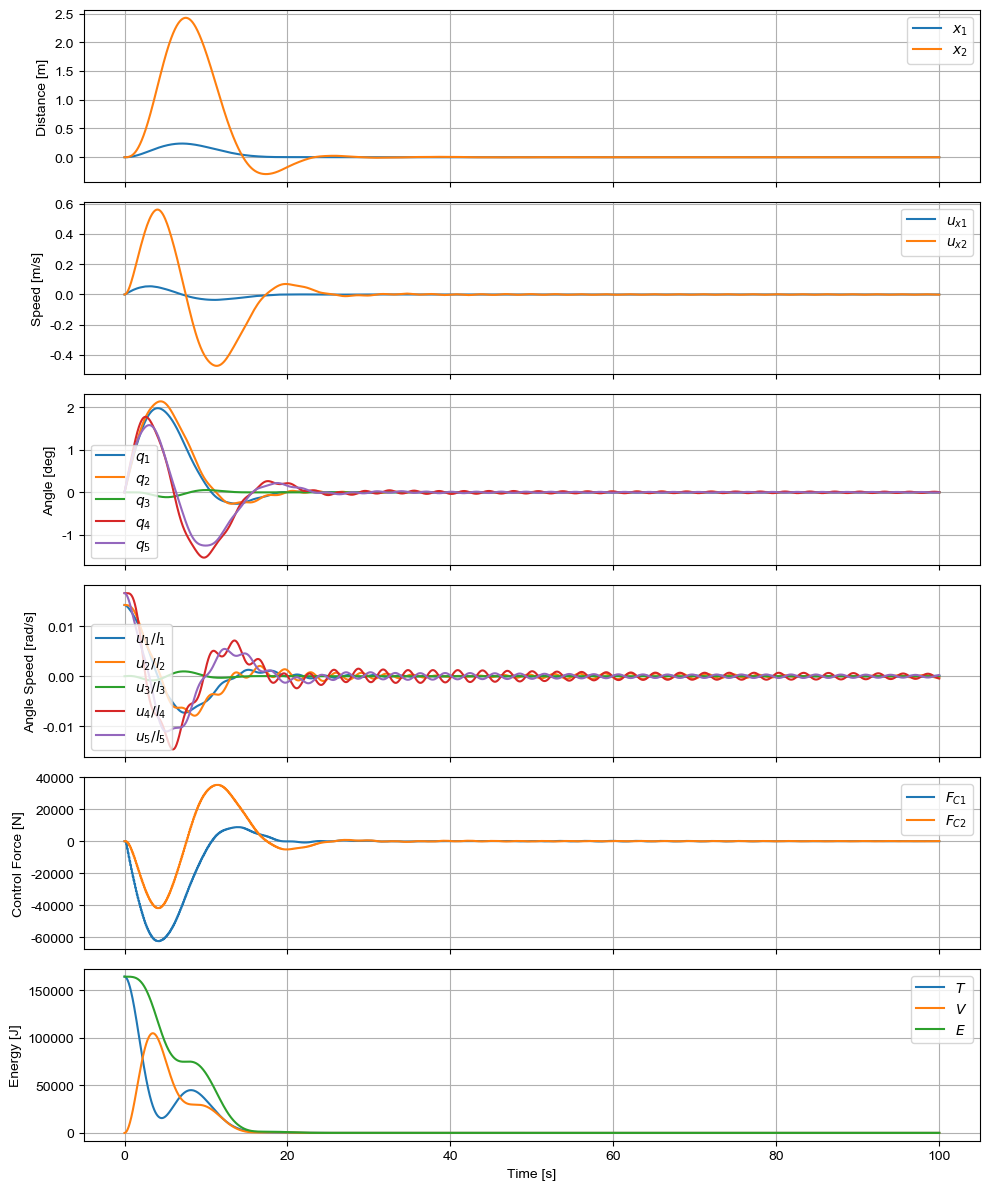

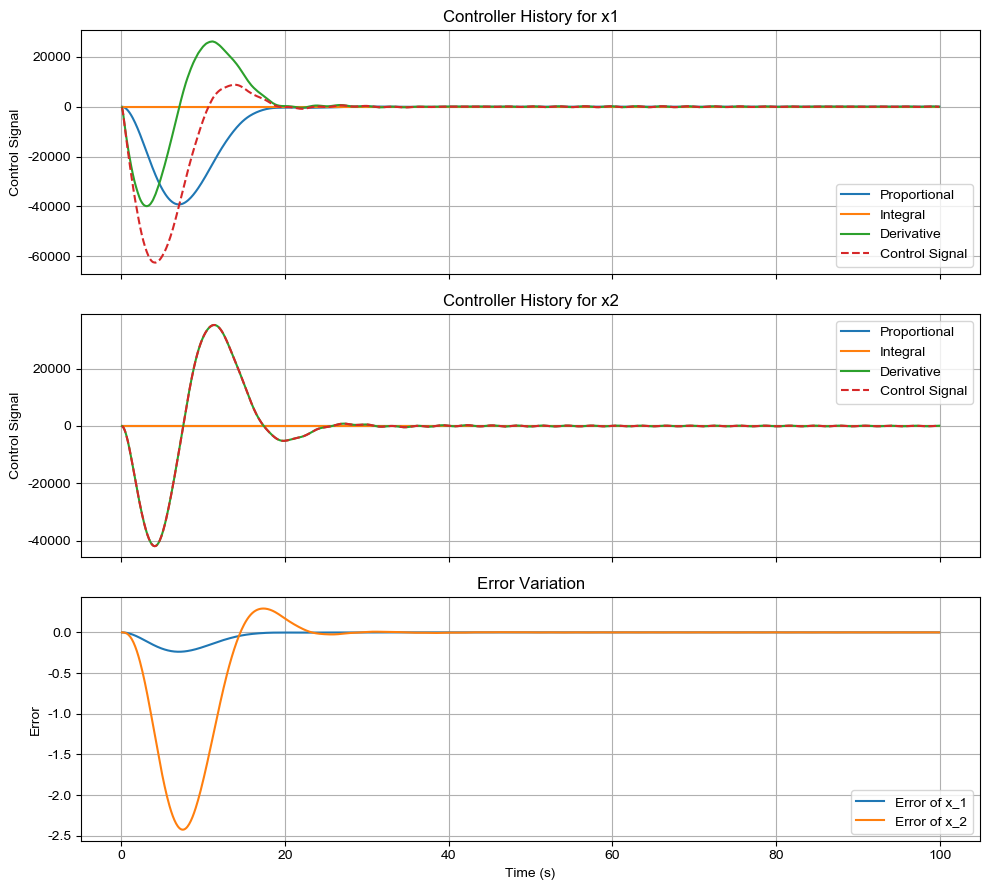

In [23]:
best_params_woa = np.insert(best_params_woa,2,[0,0])
systemfunc.update_PID_params(best_params_woa)
systemfunc.run()
print(systemfunc.getOptimizedResult(objective="ITAE"))
systemfunc.plot_results_control_all()
systemfunc.control_strategy.plot_history_all()

In [ ]:
new_PID = np.array([0.00000000e+00, 1.00000000e+06, 0.00000000e+00, 3.78500556e+02,
  6.34825792e+04, 1.00000000e+06])
new_PID = np.array([ 1.00000000e+06,0.00000000e+00, 3.78500556e+02, 0.00000000e+00, 1.00000000e+06,
  6.34825792e+04])
new_PID  = np.array([1.00000000e+07, 1.00000000e+07, 8.68156862e+02, 1.00000000e+03,
  1.72823700e+06, 1.70848187e+06])

# new_PID  = np.array([100000.,  0.,  0.,  0.,
#  342967.02591523,  78150.85514964])
new_PID  = np.array([    0. ,     0. ,     0. ,     0. ,
 83633.67514951, 52866.81069078])

new_PID = np.array([9.56754385e+06, 0.00000000e+00, 4.04775604e+01, 4.94524470e-02,
 4.66566332e+05, 7.45956271e+04])

new_PID =np.array([648016.18957099, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1465296.89108038, 66625.6135502 ])

systemfunc.update_PID_params(new_PID)
systemfunc.run()
print(systemfunc.getOptimizedResult(objective="ITAE"))
systemfunc.plot_results_control_all()
# tool.compare_models_dynamic(systemfunc.ts_dae,[systemfunc.xs_dae[:,:2],],['My',],add_itae=True,itae_starts=x0_CDPD[:2],itae_targets=target,desired_settling_time=100)
systemfunc.control_strategy.plot_history_all()

In [24]:
pos_p_0 = compute_Pp(p_vals_CDPD[5], p_vals_CDPD[6], p_vals_CDPD[0], p_vals_CDPD[1],x0_CDPD[2], x0_CDPD[3], x0_CDPD[4])
target_p = pos_p_0[0]
value = ITAE_calc(target_p, systemfunc.params, systemfunc.ts_dae, systemfunc.xs_dae)
print("ITAEp:", value)
ITAEc1 = ITAE_calc_x1(0, systemfunc.ts_dae, systemfunc.xs_dae)
ITAEc2 = ITAE_calc_x2(x0_CDPD[1], systemfunc.ts_dae, systemfunc.xs_dae)
print("ITAEc1:", ITAEc1)
print("ITAEc2:", ITAEc2)
overshootc1 = max(systemfunc.xs_dae[:,0]-systemfunc.xs_dae[0,0]) 
print("overshootc1:", overshootc1)
overshootc2 = max(systemfunc.xs_dae[:,1]-systemfunc.xs_dae[0,1]) 
print("overshootc2:", overshootc2)
overshootp = max(np.array([compute_Pp(p_vals_CDPD[5], p_vals_CDPD[6], p_vals_CDPD[0], p_vals_CDPD[1],theta1, theta2, theta3)[0] for theta1, theta2, theta3 in zip(systemfunc.xs_dae[:, 2], systemfunc.xs_dae[:, 3], systemfunc.xs_dae[:, 4])])+ systemfunc.xs_dae[:,0]) - pos_p_0[0]
print("overshootp:", overshootp)
# settling_time = systemfunc.control_strategy.compute_settling_time(target, systemfunc.ts_dae, systemfunc.xs_dae)
# print("settling_time:", settling_time)

ITAEp: 109.9971105122511
ITAEc1: 17.10690096317894
ITAEc2: 170.1053062832666
overshootc1: 0.2381877959280156
overshootc2: 2.42544850255085
overshootp: 2.643394609284096


In [25]:
def compute_settling_time(target, time, states, tolerance=0.01):
    """
    计算信号稳定到目标值附近的时间。

    参数:
    target: 目标值。
    time: 时间序列，NumPy 数组。
    states: 状态序列，NumPy 数组。
    tolerance: 稳定容差范围。

    返回值:
    稳定时间，如果信号未稳定则返回 inf。
    """
    # 计算信号与目标值的差的绝对值
    abs_diff = np.abs(states - target)

    # 找到信号首次进入容差范围的时间点
    settled = np.where(abs_diff <= tolerance)[0]

    # 如果信号从未进入容差范围，则返回 inf
    if settled.size == 0:
        return float('inf')

    # 找到信号最后一次离开容差范围的时间点
    last_excursion = 0
    for i in range(settled[0], len(states)):
        if abs_diff[i] > tolerance:
            last_excursion = i
    
    # 稳定时间为最后一次离开容差范围后的第一个进入容差范围的时间
    settling_index = np.where(abs_diff[last_excursion:] <= tolerance)[0]
    
    if settling_index.size == 0:
        return float('inf')
    
    settling_time = time[settling_index[0] + last_excursion]
    return settling_time


In [26]:
settling_time_c1 = compute_settling_time(systemfunc.xs_dae[0,0], systemfunc.ts_dae, systemfunc.xs_dae[:,0])
settling_time_c2 = compute_settling_time(systemfunc.xs_dae[0,1], systemfunc.ts_dae, systemfunc.xs_dae[:,1])
settling_time_p = compute_settling_time(target_p, systemfunc.ts_dae, np.array([compute_Pp(p_vals_CDPD[5], p_vals_CDPD[6], p_vals_CDPD[0], p_vals_CDPD[1],theta1, theta2, theta3)[0] for theta1, theta2, theta3 in zip(systemfunc.xs_dae[:, 2], systemfunc.xs_dae[:, 3], systemfunc.xs_dae[:, 4])])+ systemfunc.xs_dae[:,0])

print("settling_time_c1:", settling_time_c1)
print("settling_time_c2:", settling_time_c2)
print("settling_time_p:", settling_time_p)

settling_time_c1: 17.001700170017003
settling_time_c2: 27.672767276727676
settling_time_p: 28.642864286428644


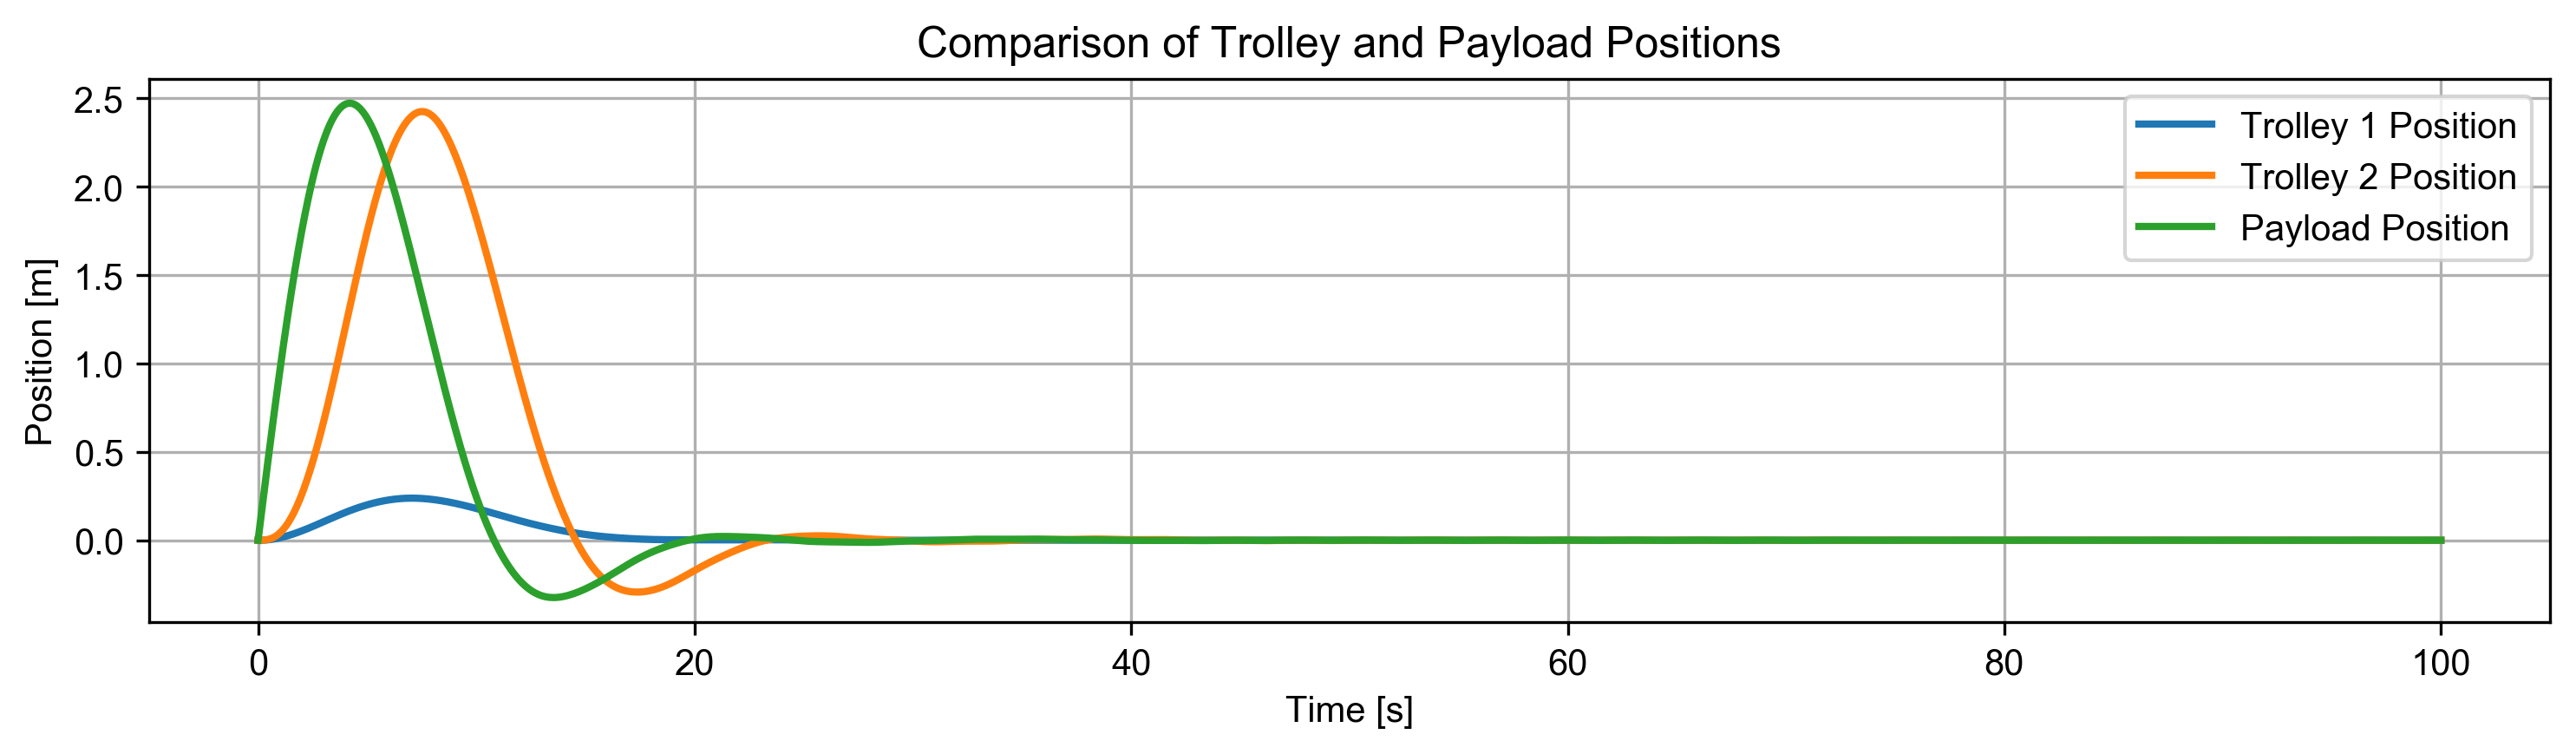

In [28]:
compare_trolley_and_payload_positions(systemfunc)

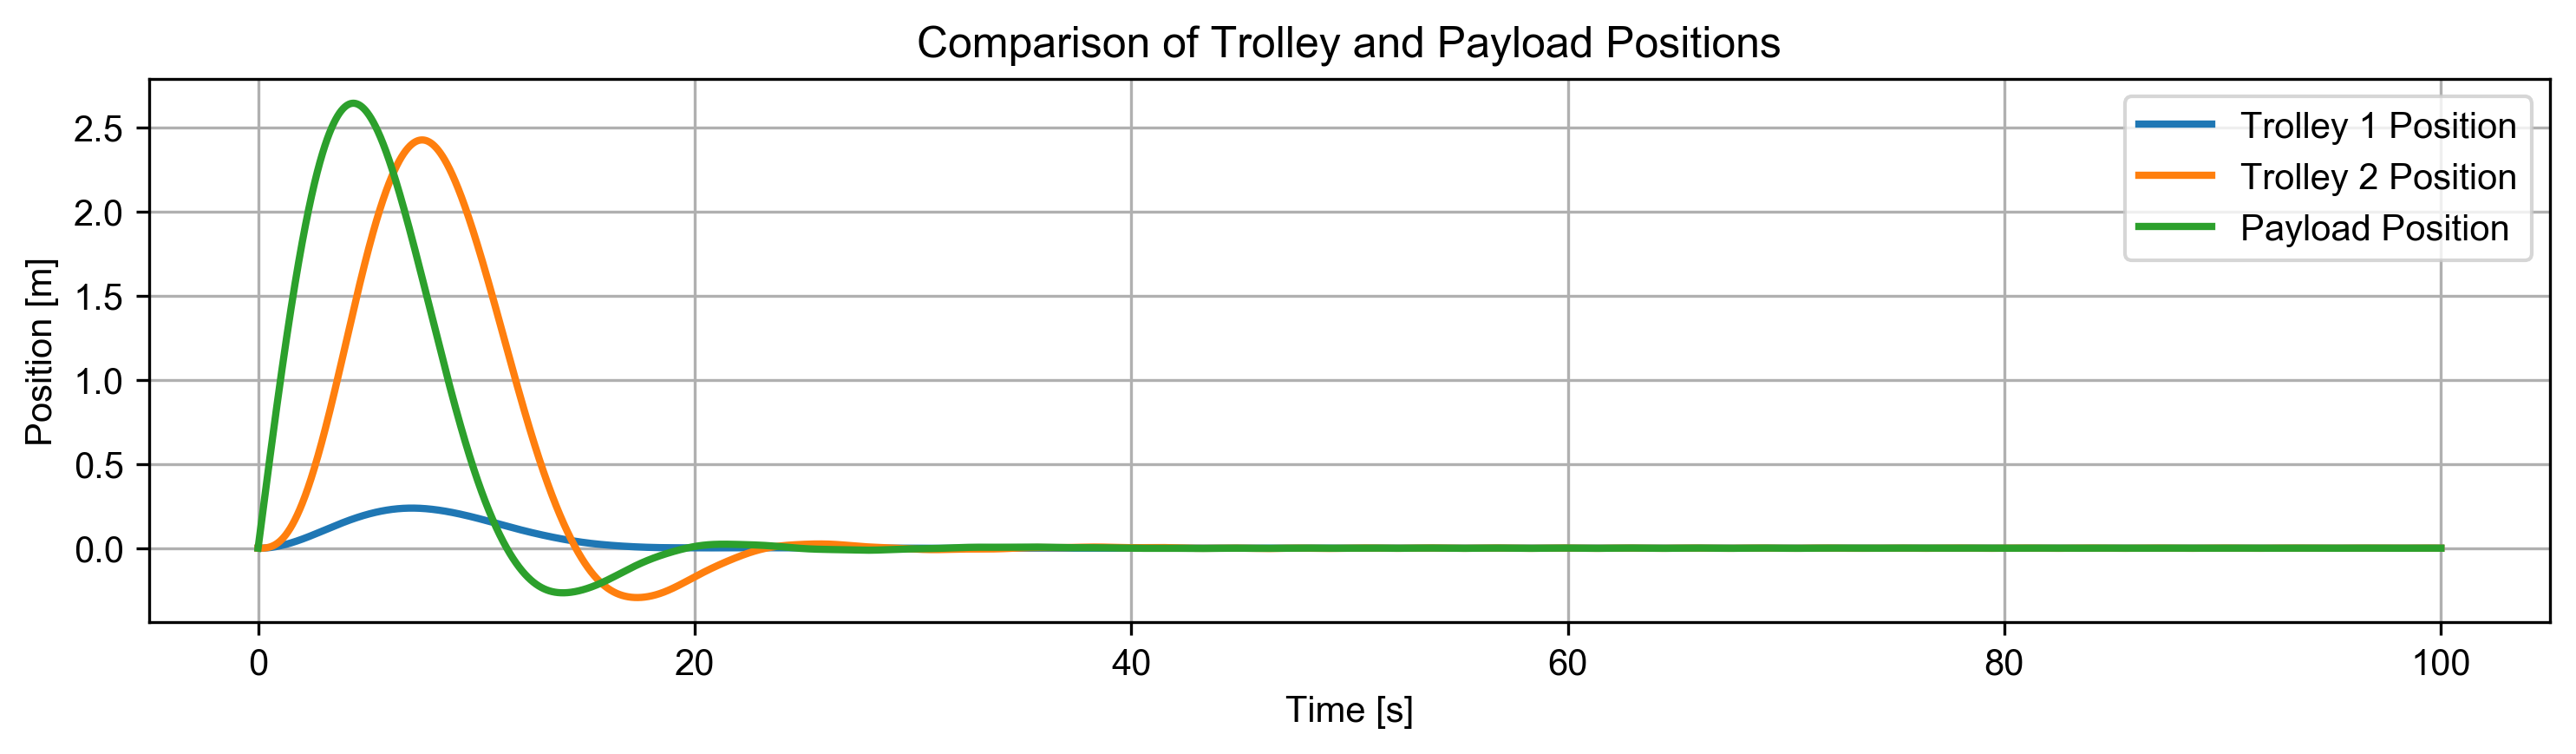

In [27]:
compare_trolley_and_payload_positions_absolute(systemfunc)

In [ ]:
objective1_function(best_params_woa)

190.8485333933578


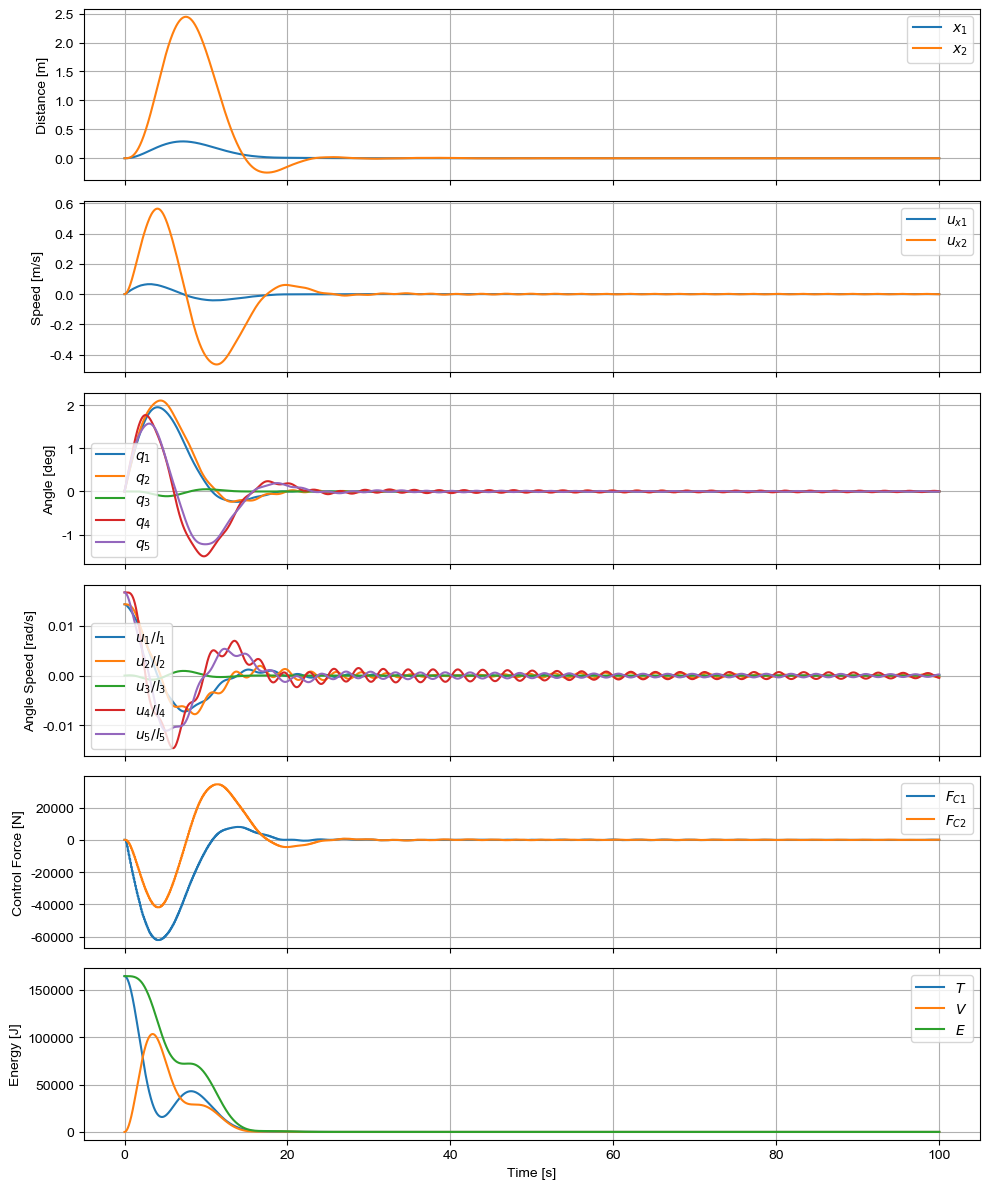

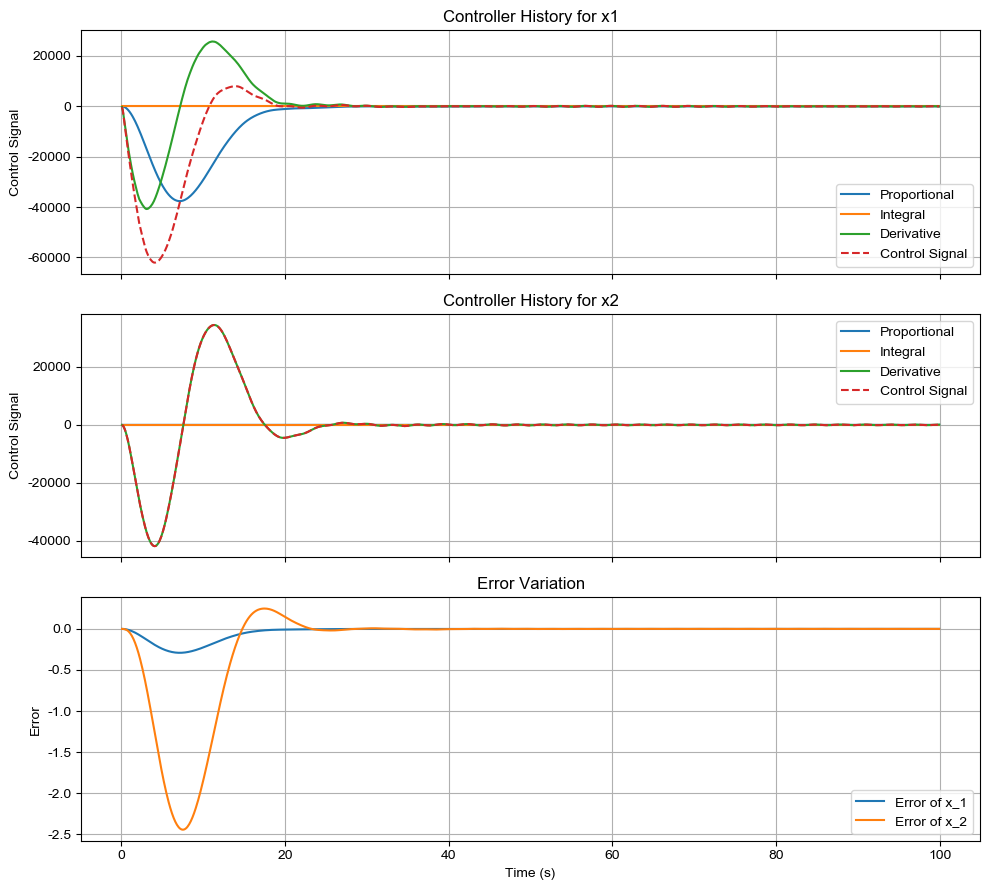

In [27]:
params_woa = np.power(10, np.array([ 5.11131262, 0.90890008, -3.  , -3.  , 5.7905119 , 4.86859459]))
systemfunc.update_PID_params(params_woa)
systemfunc.run()
print(systemfunc.getOptimizedResult(objective="ITAE"))
systemfunc.plot_results_control_all()
systemfunc.control_strategy.plot_history_all()
xs_left = systemfunc.xs_dae.copy()

213.2863282854672


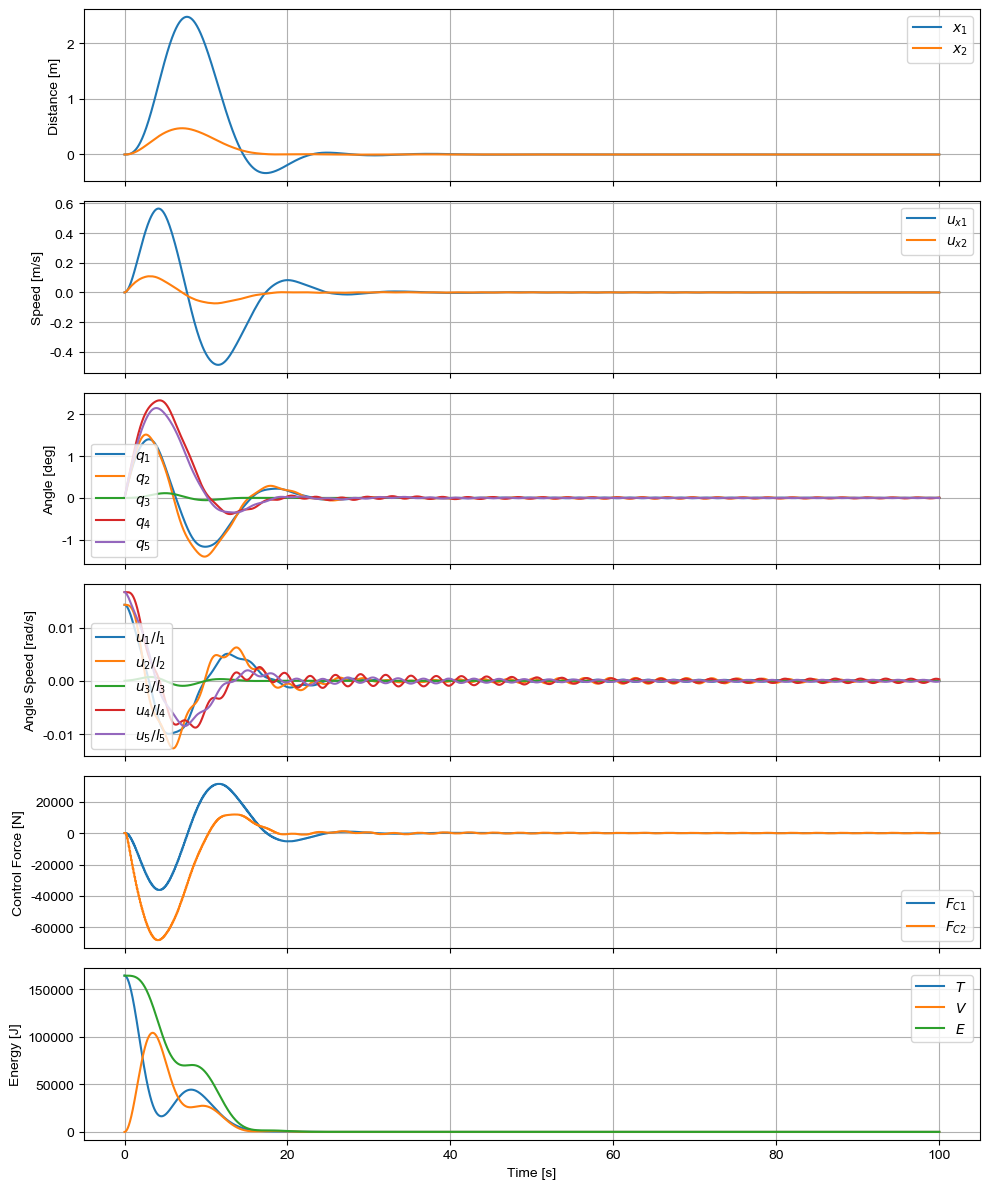

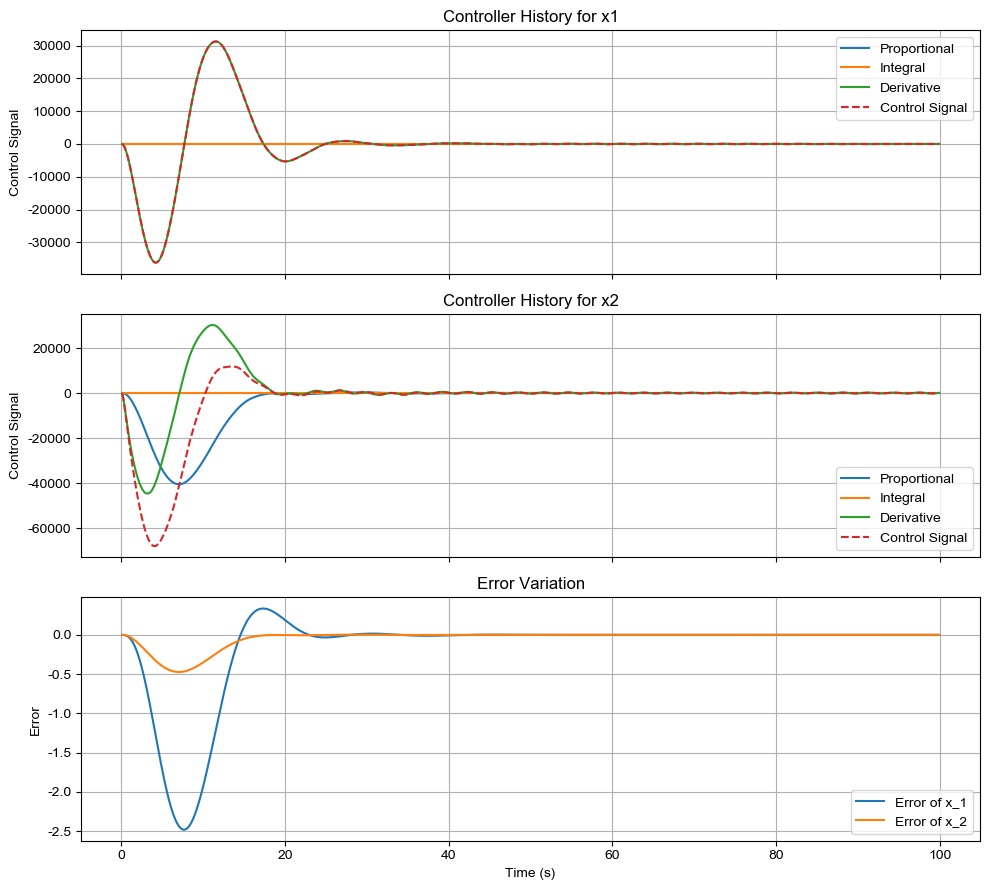

In [28]:
params_woa = np.power(10, np.array([ 0.58194277,  4.93330981, -2.23631215, -0.44373221,  4.80609935,  5.61195785]))
systemfunc.update_PID_params(params_woa)
systemfunc.run()
print(systemfunc.getOptimizedResult(objective="ITAE"))
systemfunc.plot_results_control_all()
systemfunc.control_strategy.plot_history_all()
xs_right = systemfunc.xs_dae.copy()

225.63959359367038


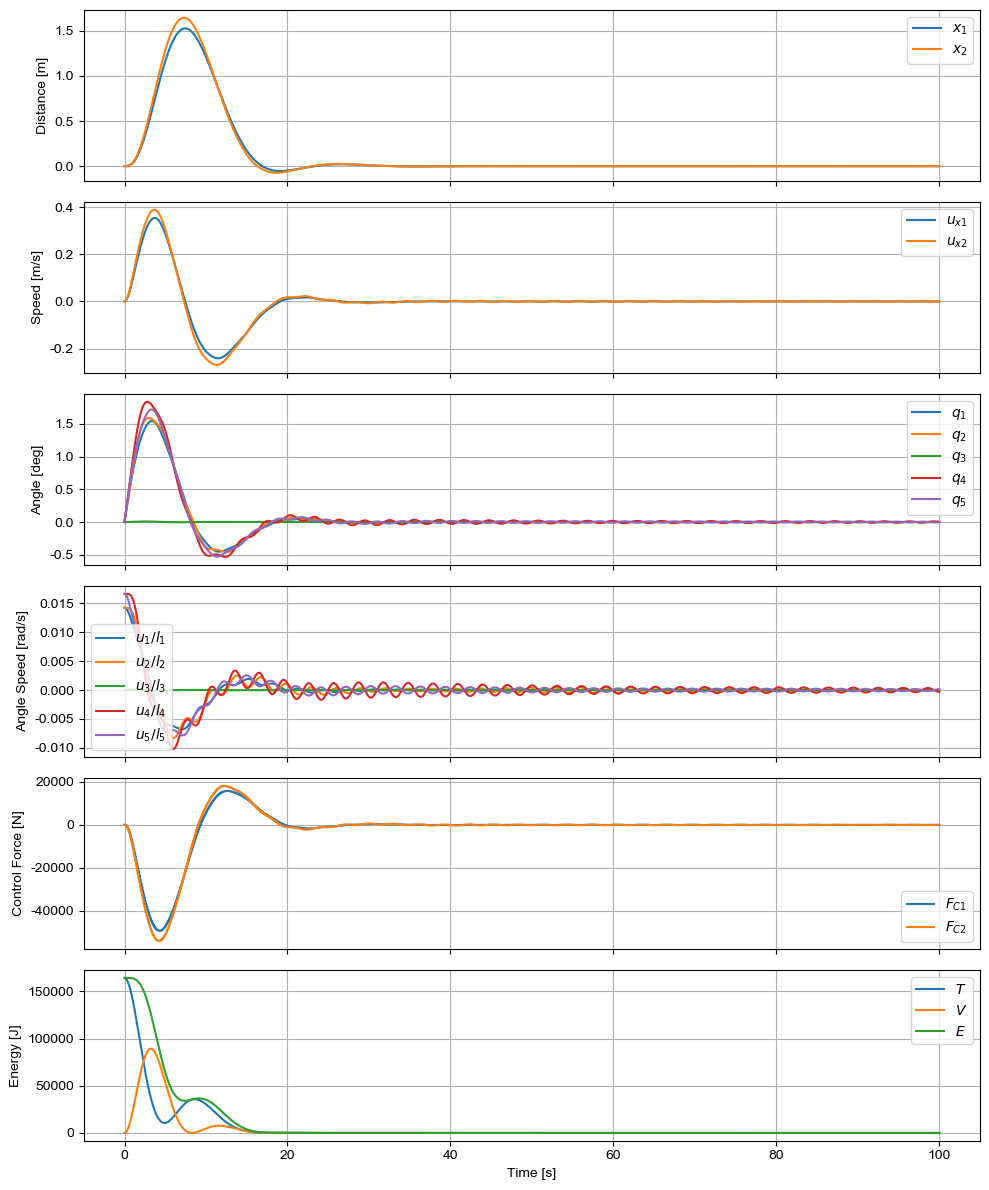

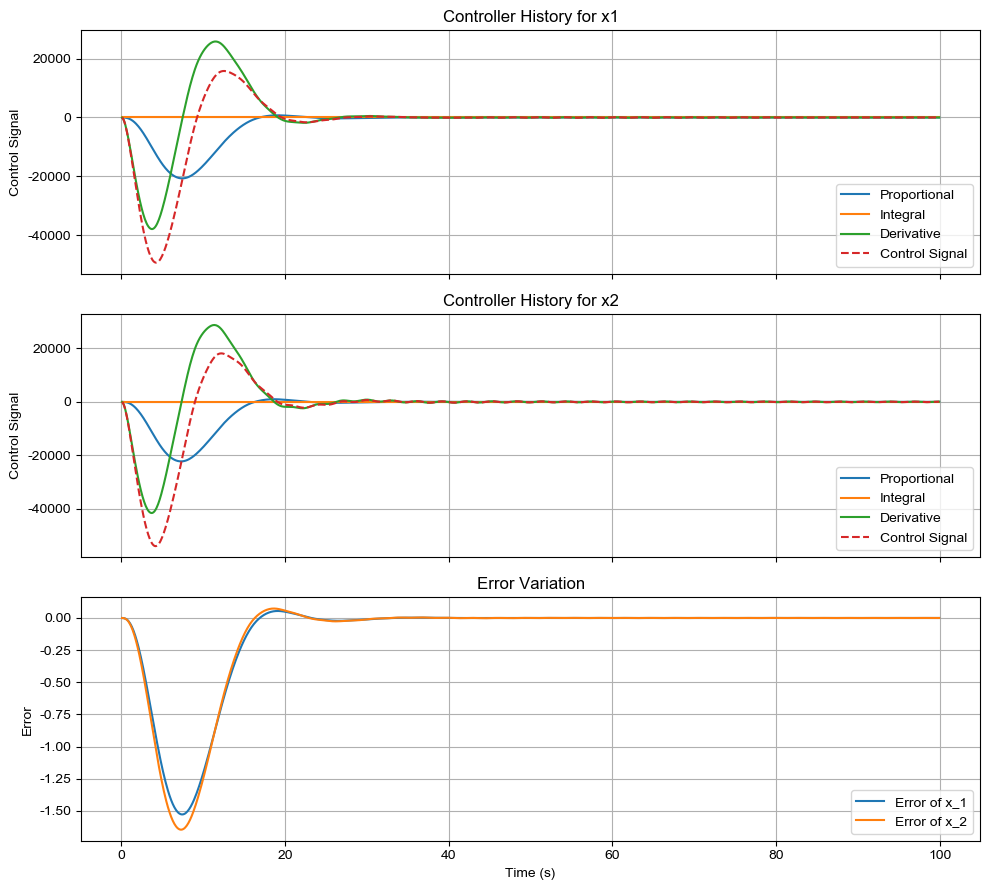

In [29]:

params_woa = np.power(10, np.array([ 4.13105417, 4.13105417, -1.61267078,-1.61267078,  5.02863031,  5.02863031]))
systemfunc.update_PID_params(params_woa)
systemfunc.run()
print(systemfunc.getOptimizedResult(objective="ITAE"))
systemfunc.plot_results_control_all()
systemfunc.control_strategy.plot_history_all()
xs_sym = systemfunc.xs_dae.copy()

=== xs_left vs xs_right ===
Overall RMSE: 0.208892
Top state diffs (state_index, rmse, max_abs, mean_abs):
  s00  rmse=0.513899  max_abs=2.19233  mean_abs=0.177723
  s01  rmse=0.461212  max_abs=1.97688  mean_abs=0.156335
  s07  rmse=0.132504  max_abs=0.508023  mean_abs=0.052381
  s08  rmse=0.117896  max_abs=0.467668  mean_abs=0.0456718
  s09  rmse=0.0882508  max_abs=0.345547  mean_abs=0.0384831
  s11  rmse=0.0722487  max_abs=0.290992  mean_abs=0.0349666
  s10  rmse=0.0459219  max_abs=0.18164  mean_abs=0.0213813
  s05  rmse=0.00863286  max_abs=0.0378274  mean_abs=0.00305117

=== xs_left vs xs_sym ===
Overall RMSE: 0.106635
Top state diffs (state_index, rmse, max_abs, mean_abs):
  s00  rmse=0.303256  max_abs=1.23718  mean_abs=0.104033
  s01  rmse=0.182126  max_abs=0.807243  mean_abs=0.0647463
  s07  rmse=0.0688979  max_abs=0.291594  mean_abs=0.026656
  s08  rmse=0.0532787  max_abs=0.197858  mean_abs=0.0210561
  s11  rmse=0.0422304  max_abs=0.160982  mean_abs=0.0185379
  s09  rmse=0.03826

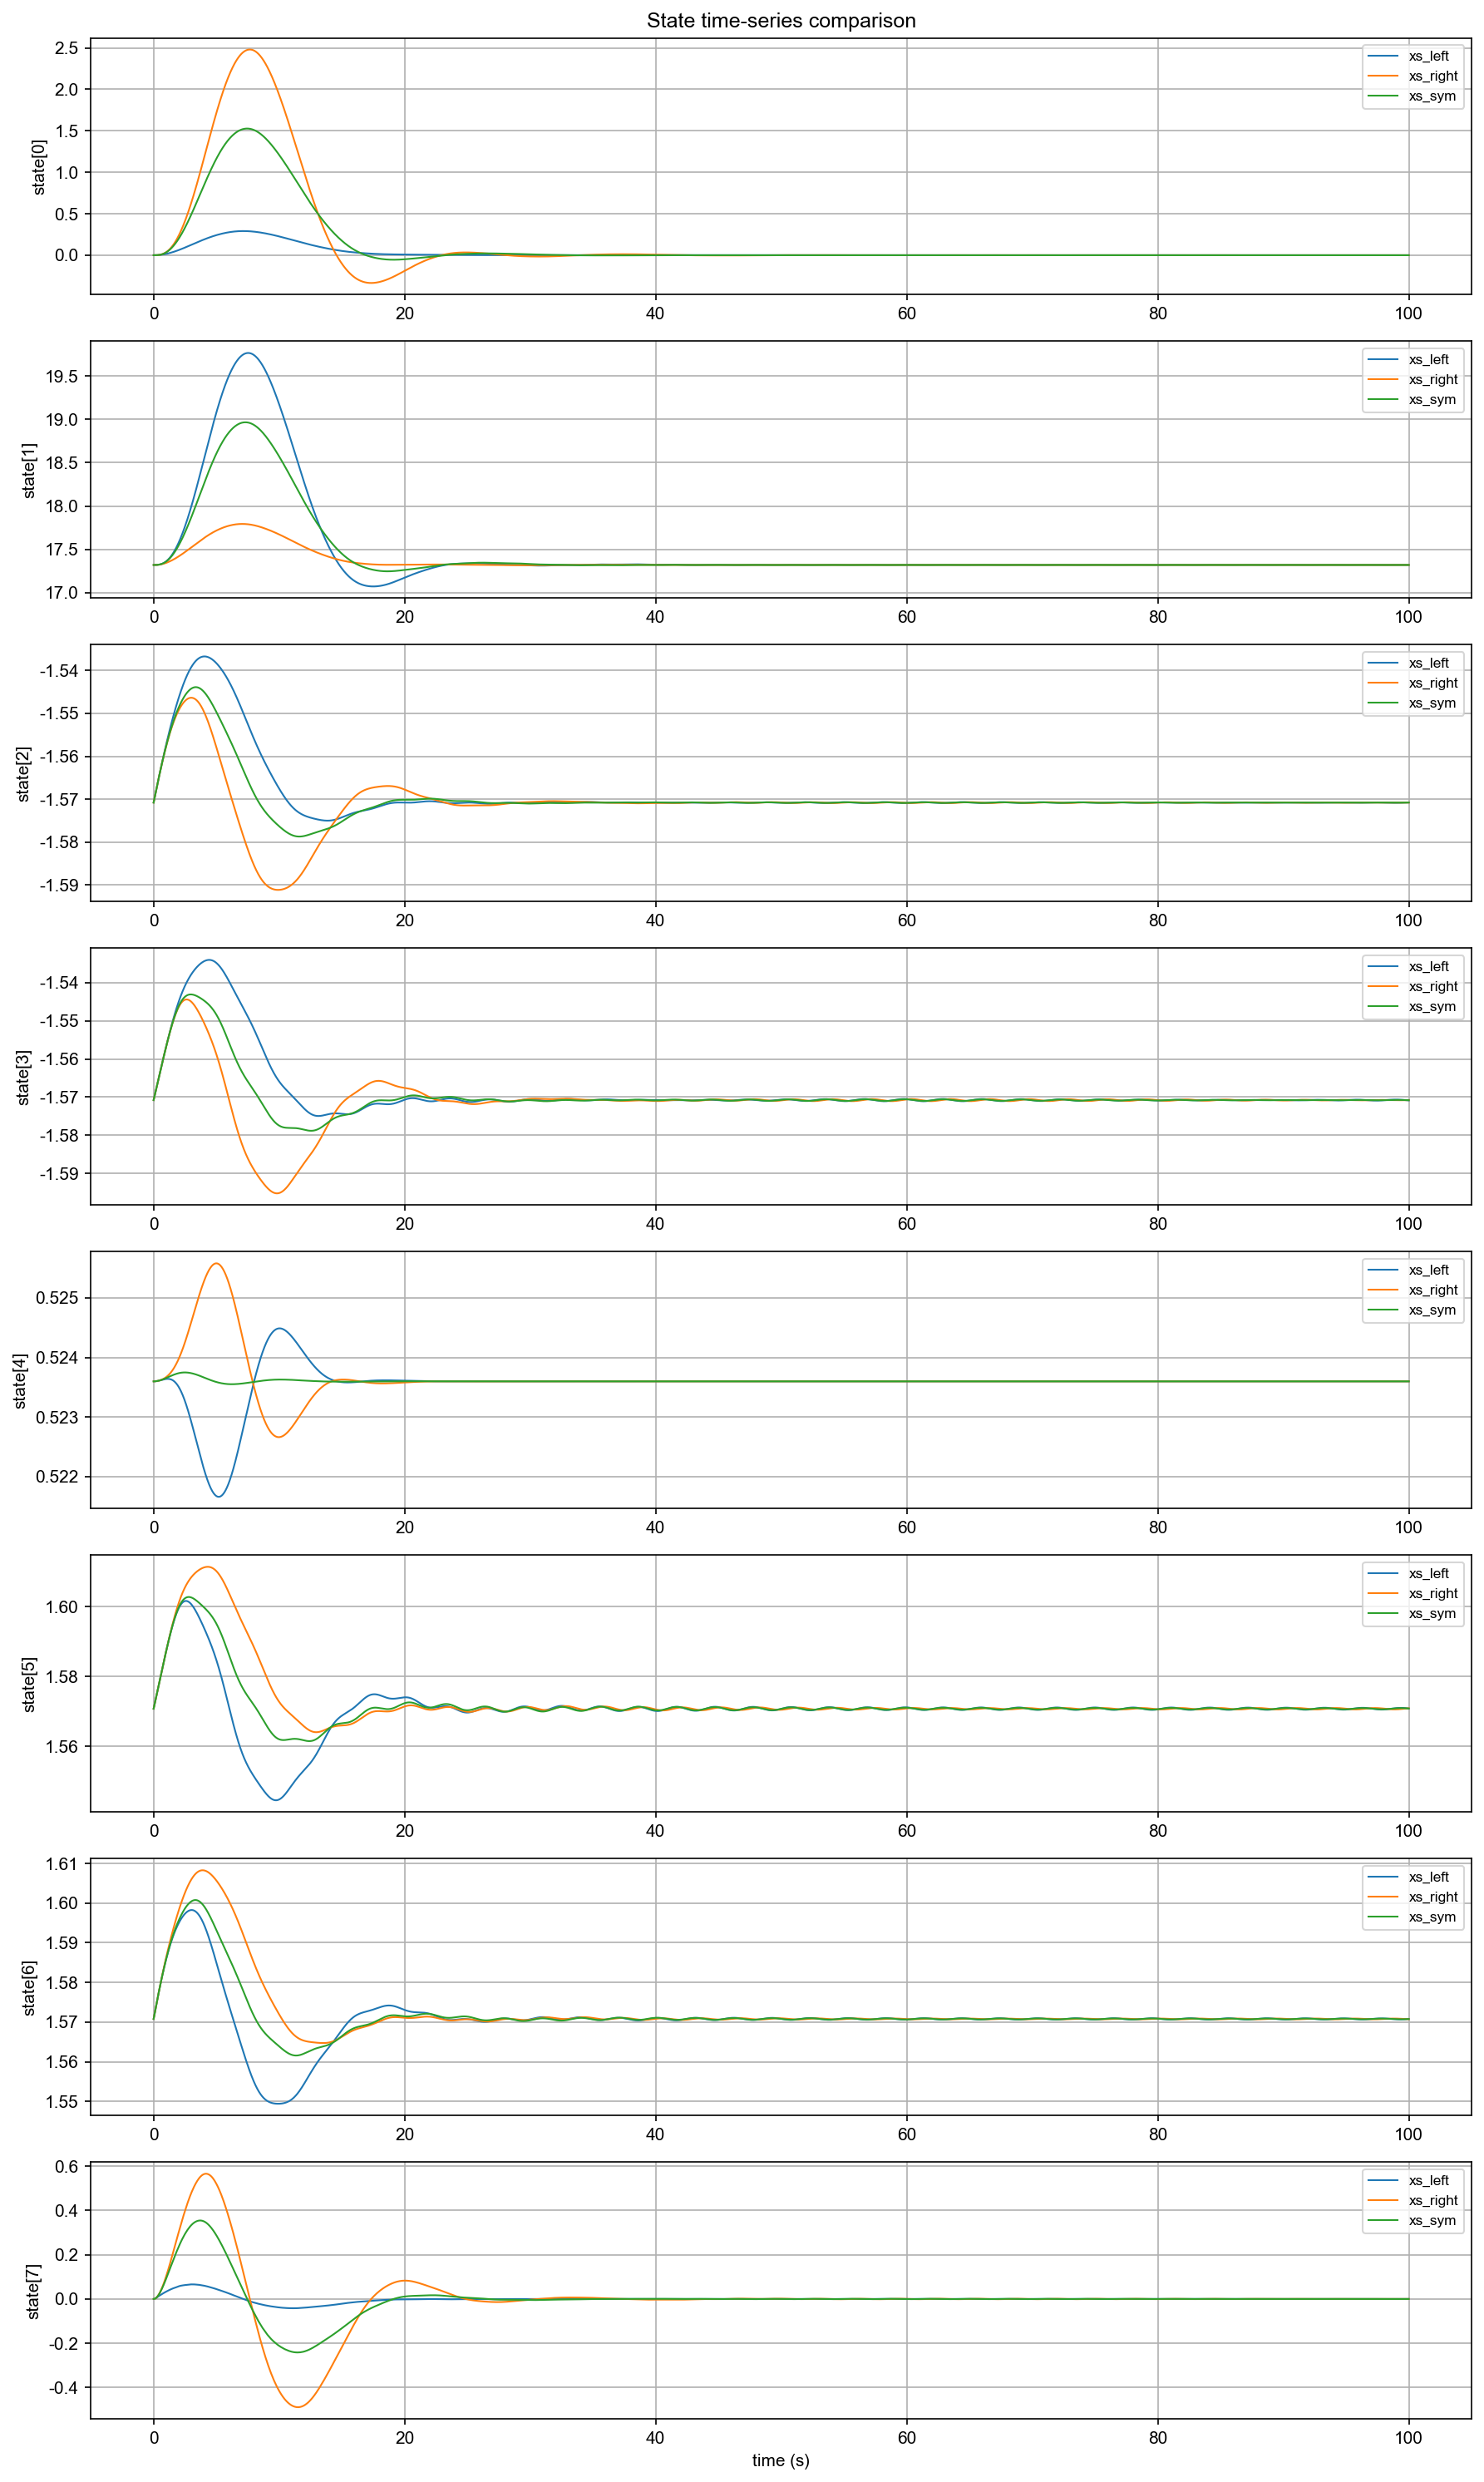

In [30]:
import numpy as _np
from itertools import combinations

# 比较 xs_left, xs_right, xs_sym 的各项数据：逐列误差统计 + 若干状态的时序对比图
# 假定 xs_* 行数与 systemfunc.ts_dae 对应（若行数不同，按最小长度截断）

def compare_state_arrays(arrs, names, ts=None, n_plot_states=6):
    """
    arrs: list of np.ndarray with shape (T, n_states)
    names: list of str names, same length as arrs
    ts: time vector, length >= min(Ts). 若为 None，则使用 range.
    n_plot_states: number of leading state indices to plot (0..n_plot_states-1)
    """
    import matplotlib.pyplot as _plt

    # 检查输入
    assert len(arrs) == len(names), "arrs 和 names 长度需对应"

    # 截取到最小时间步长以便逐元素比较
    min_T = min(a.shape[0] for a in arrs)
    n_states = arrs[0].shape[1]
    arrs_trunc = [_a[:min_T, :n_states] for _a in arrs]

    if ts is None:
        t = _np.arange(min_T)
    else:
        t = ts[:min_T]

    # 计算 pairwise 误差矩阵：对于每对 (i,j) 计算 RMSE, max abs, mean abs 每列
    summary = {}
    for i, j in combinations(range(len(arrs_trunc)), 2):
        A = arrs_trunc[i]
        B = arrs_trunc[j]
        diff = A - B
        rmse = _np.sqrt(_np.mean(diff**2, axis=0))
        max_abs = _np.max(_np.abs(diff), axis=0)
        mean_abs = _np.mean(_np.abs(diff), axis=0)
        overall_rmse = _np.sqrt(_np.mean(diff**2))
        key = f"{names[i]} vs {names[j]}"
        summary[key] = {
            'rmse_per_state': rmse,
            'max_abs_per_state': max_abs,
            'mean_abs_per_state': mean_abs,
            'overall_rmse': overall_rmse
        }

    # 打印摘要（整体 RMSE 与每列的 top-5 差异最大状态）
    for k, v in summary.items():
        print("===", k, "===")
        print(f"Overall RMSE: {v['overall_rmse']:.6g}")
        # 找出每列 rmse, 显著差异前 8 个
        idx_sorted = _np.argsort(-v['rmse_per_state'])
        topk = idx_sorted[:8]
        print("Top state diffs (state_index, rmse, max_abs, mean_abs):")
        for idx in topk:
            print(f"  s{idx:02d}  rmse={v['rmse_per_state'][idx]:.6g}  max_abs={v['max_abs_per_state'][idx]:.6g}  mean_abs={v['mean_abs_per_state'][idx]:.6g}")
        print("")

    # 绘图：前 n_plot_states 列在时间上的对比（若 n_plot_states > n_states，限制到 n_states）
    n_plot = min(n_plot_states, n_states)
    _plt.figure(figsize=(12, 2.5 * n_plot), dpi=150)
    for si in range(n_plot):
        ax = _plt.subplot(n_plot, 1, si+1)
        for a, name in zip(arrs_trunc, names):
            ax.plot(t, a[:, si], label=name, linewidth=1)
        ax.set_ylabel(f"state[{si}]")
        ax.grid(True)
        if si == 0:
            ax.set_title("State time-series comparison")
        if si == n_plot-1:
            ax.set_xlabel("time (s)" if ts is not None else "index")
        ax.legend(fontsize='small')
    _plt.tight_layout()
    _plt.show()

    # 返回 summary 以便后续程序使用
    return summary

# 使用 notebook 中的变量
arrs = [xs_left, xs_right, xs_sym]
names = ['xs_left', 'xs_right', 'xs_sym']
ts = getattr(systemfunc, 'ts_dae', None)
summary = compare_state_arrays(arrs, names, ts=ts, n_plot_states=8)